<a href="https://colab.research.google.com/github/yuchenhe-xai/yccolab/blob/main/241015_exp_runs_rubrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [7]:
import ast
import asyncio
import glob
import json
import logging
import os
import re
import traceback
from typing import Any
import pandas as pd
import copy
import numpy as np

import uuid
from xlm.config import configclass
from xlm.posttrain import utils
from xlm.posttrain.data import formatting
from xlm.posttrain.evals.eval_base import SamplerEvalBase
from xlm.sampling_client import SamplingClient

In [8]:
import markdown
from markdown.extensions.tables import TableExtension
from IPython.display import HTML, display

def display_conversation(conversation, conv_loss_mask=None):
    """
    Display a conversation in a notebook with different colors for the 'user' and 'assistant' roles,
    supporting Markdown formatting with correct table rendering.

    Parameters:
    - conversation (list of dict): List of dictionaries containing 'role' and 'content'.
    - conv_loss_mask (list of bool): List of boolean values indicating whether to highlight the message.
    """
    user_bg_color = "#d0e7ff"  # light blue for user messages
    assistant_bg_color = "#d4edda"  # light green for assistant messages
    user_text_color = "#084298"  # darker blue for user text
    assistant_text_color = "#155724"  # darker green for assistant text
    html_output = ""

    # Setting up Markdown with table support
    md = markdown.Markdown(extensions=[TableExtension(use_align_attribute=True)])

    for i, entry in enumerate(conversation):
        role = entry["role"]
        content = entry["content"]
        is_user = role.lower() in ["user", "human"]

        # Set color based on role
        bg_color = user_bg_color if is_user else assistant_bg_color
        text_color = user_text_color if is_user else assistant_text_color
        role_display = "User" if is_user else "Assistant"

        # Convert Markdown to HTML, ensuring tables are rendered correctly
        content_html = md.convert(content)

        # Highlight if conv_loss_mask is True for this message
        highlight_style = "font-weight: bold; text-decoration: underline;" if conv_loss_mask and conv_loss_mask[i] else "font-weight: normal;"

        # Append each entry to HTML string with styling
        html_output += f"""
        <div style='background-color: {bg_color}; color: {text_color};
                    border-radius: 8px; padding: 10px; margin: 8px 0;'>
            <strong style='{highlight_style}'>{role_display}:</strong>
            <div style='{highlight_style}'>{content_html}</div>
        </div>
        """

    display(HTML(html_output))

# Inspect Preference Data 10/15


In [ ]:
data_path = "/data/datasets/preferences-v2/mixture/surge1t10/train/*.parquet"
df_data = utils.read_df(glob.glob(data_path))

reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:06<00:00, 11.05it/s]


In [ ]:
for idx, (_, row) in enumerate(df_data.iterrows()):
  example = row.to_dict()
  break


905568

In [ ]:
df_data

,data0,data1,conversation0,conversation1,prompt,preference_overall,id,src_path,dataset,domain,preference_quality,preference_instruction-following,preference_correctness,preference_writing,critic,preference_verbosity
0,"Human: Based off of this text, tell me in a si...","Human: Based off of this text, tell me in a si...","[{'content': 'Based off of this text, tell me ...","[{'content': 'Based off of this text, tell me ...","Human: Based off of this text, tell me in a si...",0.50,785b1621-4081-4c1a-96d1-72db350f3c66:1,/data/datasets/preferences-v2/raw/surge_finegr...,surge_finegrain_general_6,Closed Q&A,0.500,-100.0,-100.0,-100.0,Both responses answer the prompt according to ...,1.000000
1,Human: You are a wizard from the wizarding wor...,Human: You are a wizard from the wizarding wor...,[{'content': 'You are a wizard from the wizard...,[{'content': 'You are a wizard from the wizard...,Human: You are a wizard from the wizarding wor...,0.50,dd04e1f6-c670-4c45-aa32-4b3206033a35:2,/data/datasets/preferences-v2/raw/surge_finegr...,surge_finegrain_general_8,Open Q&A,0.375,-100.0,0.5,-100.0,Both responses have major inaccuracies because...,-100.000000
2,Human: Please write three separate description...,Human: Please write three separate description...,[{'content': 'Please write three separate desc...,[{'content': 'Please write three separate desc...,Human: Please write three separate description...,0.66,184cf9c8-a3a8-4412-8bfe-039a83cc520f:3,/data/datasets/preferences-v2/raw/surge_finegr...,surge_finegrain_general_4,Summarization,0.500,-100.0,-100.0,-100.0,Model B remembered to bold the athlete or team...,0.500000
3,Human: Please act as a psychiatrist having a c...,Human: Please act as a psychiatrist having a c...,[{'content': 'Please act as a psychiatrist hav...,[{'content': 'Please act as a psychiatrist hav...,Human: Please act as a psychiatrist having a c...,0.33,5045df3d-54b4-4255-bc29-c7c7fab17530:1,/data/datasets/preferences-v2/raw/surge_finegr...,surge_finegrain_general_5,Persona,0.500,-100.0,-100.0,-100.0,Model A does a better job of fulfilling the fi...,0.500000
4,Human: I am searching for phd programs to appl...,Human: I am searching for phd programs to appl...,[{'content': 'I am searching for phd programs ...,[{'content': 'I am searching for phd programs ...,Human: I am searching for phd programs to appl...,0.83,c701c6d5-f4ff-4bd3-8971-df01d112f8ec:2,/data/datasets/preferences-v2/raw/surge_finegr...,surge_finegrain_general_4,Extraction,0.625,-100.0,-100.0,-100.0,Response B is much better. Both models extract...,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56593,Human: Me and my sister are going to make cook...,Human: Me and my sister are going to make cook...,[{'content': 'Me and my sister are going to ma...,[{'content': 'Me and my sister are going to ma...,Human: Me and my sister are going to make cook...,0.33,6b7691a2-588d-485a-8da9-d2d142bc0a8a:3,/data/datasets/preferences-v2/raw/surge_finegr...,surge_finegrain_general_3,Classification,-100.000,-100.0,0.5,-100.0,"Although, the original recipe was a whoopie pi...",0.500000
56594,Human: Please provide me advice on how to disc...,Human: Please provide me advice on how to disc...,[{'content': 'Please provide me advice on how ...,[{'content': 'Please provide me advice on how ...,Human: Please provide me advice on how to disc...,0.66,47ef3c8a-18ea-47f3-b730-3192fb010a53:2,/data/datasets/preferences-v2/raw/surge_finegr...,surge_finegrain_general_5,Open Q&A,0.500,-100.0,-100.0,-100.0,"While Model A had great movie options, Model B...",0.500000
56595,Human: Brainstorm some birthday party ideas fo...,Human: Brainstorm some birthday party ideas fo...,[{'content': 'Brainstorm some birthday party i...,[{'content': 'Brainstorm some birthday party i...,Human: Brainstorm some birthday party ideas fo...,0.66,8dd04d7a-3771-4ee1-8406-3b570682abb0:2,/data/datasets/preferences-v2/raw/surge_finegr...,surge_finegrain_general_4,Open Q&A,0.625,-100.0,-100.0,-100.0

In [ ]:
example.keys()

dict_keys(['data0', 'data1', 'conversation0', 'conversation1', 'prompt', 'preference_overall', 'id', 'src_path', 'dataset', 'domain', 'preference_quality', 'preference_instruction-following', 'preference_correctness', 'preference_writing', 'critic', 'preference_verbosity'])

# Rubric Data 10/18


In [ ]:
RUBRIC_PROPOSER_PROMPT = """\
You are an educational expert to design detailed rubrics for evaluating responses to given queries:

---

Please create a set of detailed rubrics to evaluate how well an AI responds to a series of questions or commands. Here's what you need to do:

1. **Understand and Analyze the Context**: You'll be provided query to help guide your rubric creation. Please read them carefully and provide a detailed analysis report before you write any rubrics.

2. **Rubric Structure**:
   - Each rubric item should be a simple, binary (True or False) criterion focusing on one specific aspect of the response.
   - Ensure that the criteria are:
     - **Specific**: Clearly define what's being evaluated.
     - **Comprehensiveness**: Cover most significant aspects required by query including Instruction_following, Correctness, Reasoning, Clarity, Conciseness, Writing and more.
     - **Objective**: A third party should be able to unambiguously determine if the criterion is met.

3. **Example**:
- Input is:
<conversation-history>
Human: I am going to visit my college roommate Zach soon and I want to get him a gift. We both love going to Taco Bell during the school year, so I would like to get him a small gift that is Taco Bell-themed. Can you come up with 5 fun gift ideas that incorporate Taco Bell?<|separator|>

Assistant: Here are 5 fun Taco Bell-themed gift ideas for your college roommate Zach:

    1. Taco Bell Gift Card: A Taco Bell gift card is a perfect gift for any Taco Bell enthusiast. This way, Zach can enjoy his favorite menu items whenever he wants.

    2. Taco Bell Hot Sauce Packet Keychain: You can find keychains online that are designed to look like Taco Bell's iconic hot sauce packets. This is a fun and quirky gift that Zach can carry around with him.

    3. Taco Bell T-Shirt or Hoodie: There are many Taco Bell-themed t-shirts and hoodies available online, featuring the brand's logo, slogans, or even vintage designs. Pick one that you think Zach would like and wear.

    4. Taco Bell Socks: Novelty socks are always a fun gift, and you can find Taco Bell-themed socks online that feature the brand's colors, logo, or even tacos and burritos.

    5. Taco Bell Cookbook: If Zach enjoys cooking, get him a Taco Bell-inspired cookbook that features recipes for recreating his favorite menu items at home. This gift combines his love for Taco Bell with a fun culinary experience.

These gifts are all relatively small and affordable, making them perfect for a college roommate. Enjoy your visit with Zach and your shared love for Taco Bell!
</conversation-history>
<query> Can you classify these gift ideas into the following categories: clothing items and non-clothing items? </query>
- Output is ```
<analysis>
   The query requests the 5 gift ideas into 2 categories: clothing items and non-clothing items.
   The output is in the format of a table, which shows the 5 gifts and their corresponding category.
</analysis>
<rubrics>
    {{
        "criterion_1": "All five gift ideas are included in the classification.",
        "criterion_2": "Each item's classification is unambiguous and without error.",
        "criterion_3": "Taco Bell T-Shirt or Hoodie and Taco Bell Socks are classified as clothing items.",
        "criterion_4": "Taco Bell Gift Card, Taco Bell Hot Sauce Packet Keychain and Taco Bell Cookbook are classified as non-clothing items."
        ...
    }}
</rubrics>
    ```

4. **Rubric Writing Tips**:
   - If possible, directly cite the phrase or words from original query.
   - Formulate each criterion as a clear and specific statement that can be answered with a yes or no. But citeria itself should not be "Yes" or "No".
   - Only cover most significant aspects expressed in query. Do not make duplicated criteria.
   - If a prompt asks for 2 pieces of information, each piece should be a separate criterion.
   - Avoid clever or indirect phrasing. Avoid unnecessary synonyms that may confuse the verifier and be less faithful to the prompt. Stick to what's straightforward.
   - Criteria should be concrete and specific to the user prompt.

You will be provided a conversation history and a final query.
Now your input is:
<conversation-history> {history} </conversation-history>
<query> {prompt} </query>

Please think step by step, first provide detailed analysis on the <query> and list what is the most important requirements.
If the <conversation-history> is presented, you do not need to consider the requirements of the conversation-history, but only use it as more context for the requirements for the <query>.
Finally, based on the analysis of <query>, write specific and detailed rubrics. Do not generate rubrics not required in query.

The analysis shall be enclosed in <analysis></analysis>.
The rubrics shall be enclosed in <rubrics></rubrics>. The final rubrics shall be written in dictionary format, and must be json parsable.
<analysis> </analysis>
<rubrics>
{{
    'criterion_1': xxx,
    'criterion_2': xxx,
    ......
}}
</rubrics>
"""

In [ ]:
split = "valid"
human_rubric_path = f'/data/datasets/GIF/merged_1015/rl/{split}.parquet'

df_data = utils.read_df(human_rubric_path)
print("\nsize", df_data.size)
new_df_data = []
for idx, (_, row) in enumerate(df_data.iterrows()):
    example = row.to_dict()
    # print(example.keys(), example['prompt'])
    msgs = formatting.derender_conversation(
        name="grok",
        rendered_conv=formatting.strip_last_generation_prompt(example["prompt"]),
    )
    query = msgs[-1]
    history = ""
    if len(msgs) > 1:
        history = formatting.render_conversation(name="grok", messages=msgs[:-1])
        if history.endswith("<|separator|>"):
            history = history[: -len("<|separator|>")]
    # example['id'] = str(uuid.uuid4())
    user_prompt = RUBRIC_PROPOSER_PROMPT.format(history=history, prompt=query["content"])
    model_reponse_target = json.dumps(example['rubric'].tolist())
    conversation = [{"role": "user", "content": user_prompt.replace("<|separator|>", "")}, {"role": "assistant", "content": model_reponse_target}]
    example['conversation'] = conversation
    conversation_str = formatting.render_conversation(name="grok", messages=example['conversation'])
    example['conversation_str'] = conversation_str
    example["name"] = "mixture_rubrics_proposal_train-8k-v4-pack1"

    new_df_data.append(example)
new_df_data = pd.DataFrame.from_records(new_df_data)
new_df_data.to_parquet(f"/data/datasets/GIF/merged_1015/sft/{split}.parquet")
new_df_data

reading paths: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.14it/s]



size 3360


,source,task_id,category,rubric,prompt,messages,conversation,conversation_str,name
0,surge,1637a65c-caa2-4637-a122-8acbf1a86fa4,[Open QA],[The motion examples in the response should us...,Human: I'm performing a signal test to be a fo...,[{'content': 'I'm performing a signal test to ...,"[{'role': 'user', 'content': 'You are an educa...",Human: You are an educational expert to design...,mixture_rubrics_proposal_train-8k-v4-pack1
1,surge,def3d136-2fdb-4f23-b94d-b8f25dde9ad0,[Other],[The model should include 15 perks from this l...,Human: I want to learn some of the history of ...,[{'content': 'I want to learn some of the hist...,"[{'role': 'user', 'content': 'You are an educa...",Human: You are an educational expert to design...,mixture_rubrics_proposal_train-8k-v4-pack1
2,surge,a5a9df45-e868-4c96-94d7-e175eb8eb913,[Other],[The response should list the items the user w...,Human: I want to make meal for the next 3 days...,[{'content': 'I want to make meal for the next...,"[{'role': 'user', 'content': 'You are an educa...",Human: You are an educational expert to design...,mixture_rubrics_proposal_train-8k-v4-pack1
3,surge,cd319c82-0b04-4906-9eb3-a8282164fceb,[Other],[The schedule should allocate 8 uninterrupted ...,Human: I have a very important and busy week c...,[{'content': 'I have a very important and busy...,"[{'role': 'user', 'content': 'You are an educa...",Human: You are an educational expert to design...,mixture_rubrics_proposal_train-8k-v4-pack1
4,surge,d6030193-0ded-4987-aa4f-4ec01d515fba,[Asking for advice],[The table should include the price of the iPh...,Human: I need advice on whether or not I shoul...,[{'content': 'I need advice on whether or not ...,"[{'role': 'user', 'content': 'You are an educa...",Human: You are an educational expert to design...,mixture_rubrics_proposal_train-8k-v4-pack1
...,...,...,...,...,...,...,...,...,...
555,tutor,mvMFphUimxtlnDeNroOL3,[Persona],"[Response has between 166 and 183 words., Resp...",Human: It's 1978. Write a three paragraph a l...,[{'content': 'It's 1978. Write a three paragr...,"[{'role': 'user', 'content': 'You are an educa...",Human: You are an educational expert to design...,mixture_rubrics_proposal_train-8k-v4-pack1
556,tutor,xPAdVxaanoti7BxQ6WUTc,[Conversational],[The response provides 3 jokes about guns and ...,Human: my dad and i constantly argue about pol...,[{'content': 'my dad and i constantly argue ab...,"[{'role': 'user', 'content': 'You are an educa...",Human: You are an educational expert to design...,mixture_rubrics_proposal_train-8k-v4-pack1
557,tutor,OWeJ52FRgOo8kEFHmnSkk,[Conversational],[The response lists tasks that would need to b...,Human: Give me a list of the 3 best quarterbac...,[{'content': 'Give me a list of the 3 best qua...,"[{'role': 'user', 'content': 'You are an educa...",Human: You are an educational expert to design...,mixture_rubrics_proposal_train-8k-v4-pack1
558,tutor,IUfONyP9mEkn0WjFlBkGE,[Conversational],"[The response writes a joke about fairies. , T...",Human: Tell me a joke for each topic I come up...,[{'content': 'Tell me a joke for each topic I ...,"[{'role': 'user', 'content': 'You are an educa...",Human: You are an educational expert to design...,mixture_rubrics_proposal_train-8k-v4-pack1


In [ ]:
import ast, re
response = '''
 ### Analysis:
The query requests two primary actions:
1. **Rewrite and Categorize the List:** The original list of Chrome extensions provided in the conversation history needs to be grouped by categories like Time Tracking, Productivity Tools, etc., to make the information more navigable for online business owners.

2. **Grammar and Spelling Check:** The provided text should be reviewed for any spelling or grammatical issues to ensure clarity and professionalism in communication.

Here are the most important requirements based on the query:

- **Categorization:** The list must be categorized into meaningful groups related to the functionalities of the extensions, enhancing user accessibility.

- **Consistency and Accuracy in Titles and Descriptions:** When rewritten, the titles and descriptions should remain true to the original information provided. This includes accurately matching the extensions to their intended use categories.

- **Attention to Grammar:** The descriptions should be free from grammatical and spelling errors to uphold the professionalism of the list.

- **Clarity and Conciseness:** The rewritten response should be clearly presented so that users can quickly understand what each extension does.

Based on these requirements, the following rubrics will focus on these key aspects:

### Rubrics:
```json
{
    "criterion_1": "Each extension is categorized under a relevant category",
    "criterion_2": "The categories are Time-Tracking, Productivity Tools, Writing & Editing, Communication, Organization, Password Management, Focus, Browser Management, Scheduling, Email, and Lead Generation",
    "criterion_3": "The titles and descriptions of the extensions remain accurate to the original list",
    "criterion_4": "There are no spelling or grammatical errors in the revised descriptions",
    "criterion_5": "The extension titles and categories are consistently formatted",
    "criterion_6": "Each category includes an introduction or heading",
    "criterion_7": "The descriptions are clear and concise, enabling easy comprehension",
    "criterion_8": "The list is formatted in an organized manner that is visually navigable"
}
```
'''
m = re.search(r'```json\s*([\s\S]*?)\s*```', response, re.DOTALL)
res = ast.literal_eval(m.group(1).strip())
res



{'criterion_1': 'Each extension is categorized under a relevant category',
 'criterion_2': 'The categories are Time-Tracking, Productivity Tools, Writing & Editing, Communication, Organization, Password Management, Focus, Browser Management, Scheduling, Email, and Lead Generation',
 'criterion_3': 'The titles and descriptions of the extensions remain accurate to the original list',
 'criterion_4': 'There are no spelling or grammatical errors in the revised descriptions',
 'criterion_5': 'The extension titles and categories are consistently formatted',
 'criterion_6': 'Each category includes an introduction or heading',
 'criterion_7': 'The descriptions are clear and concise, enabling easy comprehension',
 'criterion_8': 'The list is formatted in an organized manner that is visually navigable'}

In [ ]:
# cd $XAI_ROOT/x/ziniu/scripts && python evaluate_rubric_rm.py
import asyncio
import glob
import pandas as pd

from xlm.posttrain import utils
from xlm.reward_client import SGLangRewardClient
import numpy as np
from typing import List, Dict, Any
from xlm.sampling_client import GrokSamplingClient, SamplingClient
from xlm.posttrain.data import formatting
from tqdm.asyncio import tqdm_asyncio
import json
from xlm.reward_client import RubricCriticRewardClient
import argparse
from xlm.posttrain.launch_utils import create_json


class RMEvaluator:
    def __init__(
        self,
        reward_model_address: str,
        max_parallel: int = 64,
    ):
        self.reward_model_address = reward_model_address
        print(reward_model_address)
        self.max_parallel = max_parallel
        self.verifier_version = "v0"

    async def setup_clients(self):
        self.client = RubricCriticRewardClient(
            address=self.reward_model_address,
            max_parallel=self.max_parallel,
            verifier_version=self.verifier_version,
        )

    async def process(self):
        print("\n=================================================")
        paths = glob.glob("/data/ziniu/rubric_datasets_merge/rewrite_rubrics.parquet")
        df = utils.read_df(paths, verbose=False)
        reward_tasks = []
        for _, example in df.iterrows():
            text = example["prompt"] + " " + example["response_0"]
            msgs = formatting.derender_conversation(name="grok", rendered_conv=text)
            rubrics = list(json.loads(example["rubric"]).values())
            reward_tasks.append(self.client.generate(messages=msgs, rubric_list=rubrics))
        rewards_0 = await tqdm_asyncio.gather(*reward_tasks)
        reward_tasks = []
        for _, example in df.iterrows():
            text = example["prompt"] + " " + example["response_1"]
            msgs = formatting.derender_conversation(name="grok", rendered_conv=text)
            rubrics = list(json.loads(example["rubric"]).values())
            reward_tasks.append(self.client.generate(messages=msgs, rubric_list=rubrics))
        rewards_1 = await tqdm_asyncio.gather(*reward_tasks)
        df["reward_0"] = [json.dumps(r, indent=2) for r in rewards_0]
        df["reward_1"] = [json.dumps(r, indent=2) for r in rewards_1]
        df["reward_0_avg"] = [r["reward"] for r in rewards_0]
        df["reward_1_avg"] = [r["reward"] for r in rewards_1]
        df.to_parquet("/data/ziniu/rubric_datasets_merge/rewrite_rubrics_w_reward.parquet")


async def main(*args):
    sampler = RMEvaluator(
        reward_model_address="v5l-16.zhu.svc.kiy.x.ai",
        max_parallel=512,
    )
    await sampler.setup_clients()
    await sampler.process()


if __name__ == "__main__":
    asyncio.run(main())


# Verifier Results 10/19

In [ ]:
paths = glob.glob("/data/yuchen/rubric_datasets_human/rewrite_rubrics_w_reward_1000.parquet")

# paths = glob.glob("/data/yuchen/rubric_datasets_human/kiy-infer.qian.svc.kiy.x.ai_zero_shot_rubrics_reward.parquet")

paths = glob.glob("/data/yuchen/rubric_datasets_human/zero_shot_rubrics_v1_sft_ref_200_reward_verifier_no_cot.parquet")

df = utils.read_df(paths, verbose=False)

In [ ]:
df

,prompt,critic,dataset,domain,response_0,response_1,preference_overall,rubric,orig_response,messages,reward_0,reward_1,reward_0_avg,reward_1_avg
0,Human: I'm getting my scuba certification in a...,Response B included locations that have flight...,surge_finegrain_general_5,Brainstorming,Congratulations on getting your scuba certific...,Here are 5 domestic and 5 international diving...,0.83,"[\n ""The response should produce a list of at...","[""The response should produce a list of at le...",[{'content': 'You are an educational expert to...,"{\n ""verifications"": [\n {\n ""outputs...","{\n ""verifications"": [\n {\n ""outputs...",0.500000,0.500000
1,"Human: Given an article from the user, your jo...",*Note - I chose Complex Extraction because the...,surge_finegrain_api_1,Extraction,Here is the analysis of the business advice pr...,Here is the analysis of the credibility of the...,0.66,"[\n ""The response should include advice title...","[""The response should include advice titles a...",[{'content': 'You are an educational expert to...,"{\n ""verifications"": [\n {\n ""outputs...","{\n ""verifications"": [\n {\n ""outputs...",0.384615,0.307692
2,"Human: I want a summary of this article, title...",Neither response does an amazing job of summar...,surge_finegrain_general_4,Summarization,"Here's a summary of the article ""5 Signs of Lo...",Title: 5 Signs Someone Might Need to Grow Up a...,0.33,"[\n ""There should be 5 main points to the art...","[""There should be 5 main points to the articl...",[{'content': 'You are an educational expert to...,"{\n ""verifications"": [\n {\n ""outputs...","{\n ""verifications"": [\n {\n ""outputs...",1.000000,1.000000
3,Human: I have a csv file containing weather da...,Model A assumes the data format of the file an...,surge_finegrain_coding_5,coding,Creating animations in Python involves using l...,Creating an animation in Python that reflects ...,1.00,"[\n ""The response identifies the need to incl...","[""The response identifies the need to include...",[{'content': 'You are an educational expert to...,"{\n ""verifications"": [\n {\n ""outputs...","{\n ""verifications"": [\n {\n ""outputs...",0.714286,0.714286
4,Human: The practice of referring to underwear ...,While both responses successfully enhanced the...,surge_finegrain_general_8,Rewriting,**CENTURIES**\n\n- **20th** - \n - Mass produ...,**CENTURIES**\n\n- **20th** - \n - Mass produ...,0.33,"[\n ""Response is placed in reverse chronologi...","[""Response is placed in reverse chronological...",[{'content': 'You are an educational expert to...,"{\n ""verifications"": [\n {\n ""outputs...","{\n ""verifications"": [\n {\n ""outputs...",1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Human: What is the pole that the author is ref...,Both responses get the answer to the question ...,surge_finegrain_general_5,Closed Q&A,The pole referred to in this excerpt is the No...,The pole referred to by the author in this exc...,0.83,"[\n ""The response states the pole being refer...","[""The response states the pole being referred...",[{'content': 'You are an educational expert to...,"{\n ""verifications"": [\n {\n ""outputs...","{\n ""verifications"": [\n {\n ""outputs...",0.500000,1.000000
193,Human: Create 10 options for brief email bodie...,Model B offers a better-formatted response giv...,surge_finegrain_general_7,Writing,Subject: Schedule Your Call - Program Details\...,Subject: Schedule a Call - After School Progra...,0.83,"[\n ""The response contains an email no more t...","[""The response contains an email no more than...",[{'content': 'You are an educational expert to...,"{\n ""verifications"": [\n {\n ""outputs...","{\n ""verifications"": [\n {\n ""outputs...",1.000000,1.000000
194,Human: I am planning to throw a gender reveal ...,Response B is much better for a few reasons. F...,surge_finegrain_general_3,Brainstorming,Here are some ideas for the Shrek-themed gende...,Here are some ideas for creating humorous a

In [ ]:
import numpy as np
from scipy.stats import spearmanr, kendalltau


def calculate_acc(df):
  import numpy as np
  from scipy.stats import spearmanr, kendalltau
  score_human = np.stack([1 - df['preference_overall'],  df['preference_overall']], axis=1)
  score_rubric_verifier = np.stack([df['reward_0_avg'], df['reward_1_avg']], axis=1)

  valid_indices = (score_human[: , 0] != score_human[:, 1]) & (score_rubric_verifier[:, 0]!= score_rubric_verifier[:, 1])
  score_human = score_human[valid_indices, :]
  score_rubric_verifier = score_rubric_verifier[valid_indices, :]

  # Sample preference scores and true labels
  label_human = score_human[: , 0] < score_human[:, 1]
  label_rubric_verifier = score_rubric_verifier[:, 0] < score_rubric_verifier[: , 1]
  print(label_human.shape, label_rubric_verifier.shape)

  # Calculate accuracy
  accuracy = np.sum(label_human == label_rubric_verifier) / len(label_human)
  print("Accuracy:", accuracy)

  alllen = len(label_human)
  # # Calculate Spearman's correlation
  spearman_corrs = np.array([spearmanr(score_human[i], score_rubric_verifier[i])[0] for i in range(alllen)])
  spearman_corrs = np.mean(spearman_corrs[~np.isnan(spearman_corrs)])
  print("Spearman's Correlation:", spearman_corrs)

  # # Calculate Kendall's Tau correlation
  kendall_corr, _ = kendalltau(label_rubric_verifier, label_human)
  print("Kendall's Tau Correlation:", kendall_corr)

  metrics = {"count" : label_human.shape[0], "accuracy": accuracy, "spearman_corrs": spearman_corrs,  "kendall_corr": kendall_corr}
  return metrics

all_metrics = calculate_acc(df)
results = [{"domain": "ALL"} | all_metrics]
all_cat = df['domain'].unique()
for cat in all_cat:
  print(cat)
  metrics = calculate_acc(df[df['domain'] == cat])
  metrics.update({"domain": cat})
  results.append(metrics)


result_df = pd.DataFrame(results)


(63,) (63,)
Accuracy: 0.6507936507936508
Spearman's Correlation: 0.3015873015873015
Kendall's Tau Correlation: 0.30879642674374563
Brainstorming
(9,) (9,)
Accuracy: 0.5555555555555556
Spearman's Correlation: 0.1111111111111111
Kendall's Tau Correlation: -0.25
Extraction
(4,) (4,)
Accuracy: 0.5
Spearman's Correlation: 0.0
Kendall's Tau Correlation: nan
Summarization
(6,) (6,)
Accuracy: 0.16666666666666666
Spearman's Correlation: -0.6666666666666666
Kendall's Tau Correlation: -0.6324555320336758
coding
(4,) (4,)
Accuracy: 1.0
Spearman's Correlation: 0.9999999999999999
Kendall's Tau Correlation: nan
Rewriting
(3,) (3,)
Accuracy: 0.6666666666666666
Spearman's Correlation: 0.3333333333333333
Kendall's Tau Correlation: nan
Open Q&A
(10,) (10,)
Accuracy: 0.7
Spearman's Correlation: 0.39999999999999997
Kendall's Tau Correlation: 0.5345224838248489
Classification
(6,) (6,)
Accuracy: 0.6666666666666666
Spearman's Correlation: 0.3333333333333333
Kendall's Tau Correlation: 0.24999999999999997
Writ

/tmp/ipykernel_92588/1931376049.py:21: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = np.sum(label_human == label_rubric_verifier) / len(label_human)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
result_df = result_df.sort_values('count', ascending=False)
# df[(df["preference_overall"] - 0.5) * (df["reward_0_avg"] - df["reward_1_avg"]) > 0 ]


In [ ]:
result_df

,domain,count,accuracy,spearman_corrs,kendall_corr
0,ALL,63,0.650794,0.301587,0.308796
6,Open Q&A,10,0.700000,0.400000,0.534522
1,Brainstorming,9,0.555556,0.111111,-0.250000
3,Summarization,6,0.166667,-0.666667,-0.632456
7,Classification,6,0.666667,0.333333,0.250000
8,Writing,5,1.000000,1.000000,1.000000
2,Extraction,4,0.500000,0.000000,NaN
4,coding,4,1.000000,1.000000,NaN
11,Advice,4,0.500000,0.000000,-0.333333
5,Rewriting,3,0.666667,0.333333,NaN


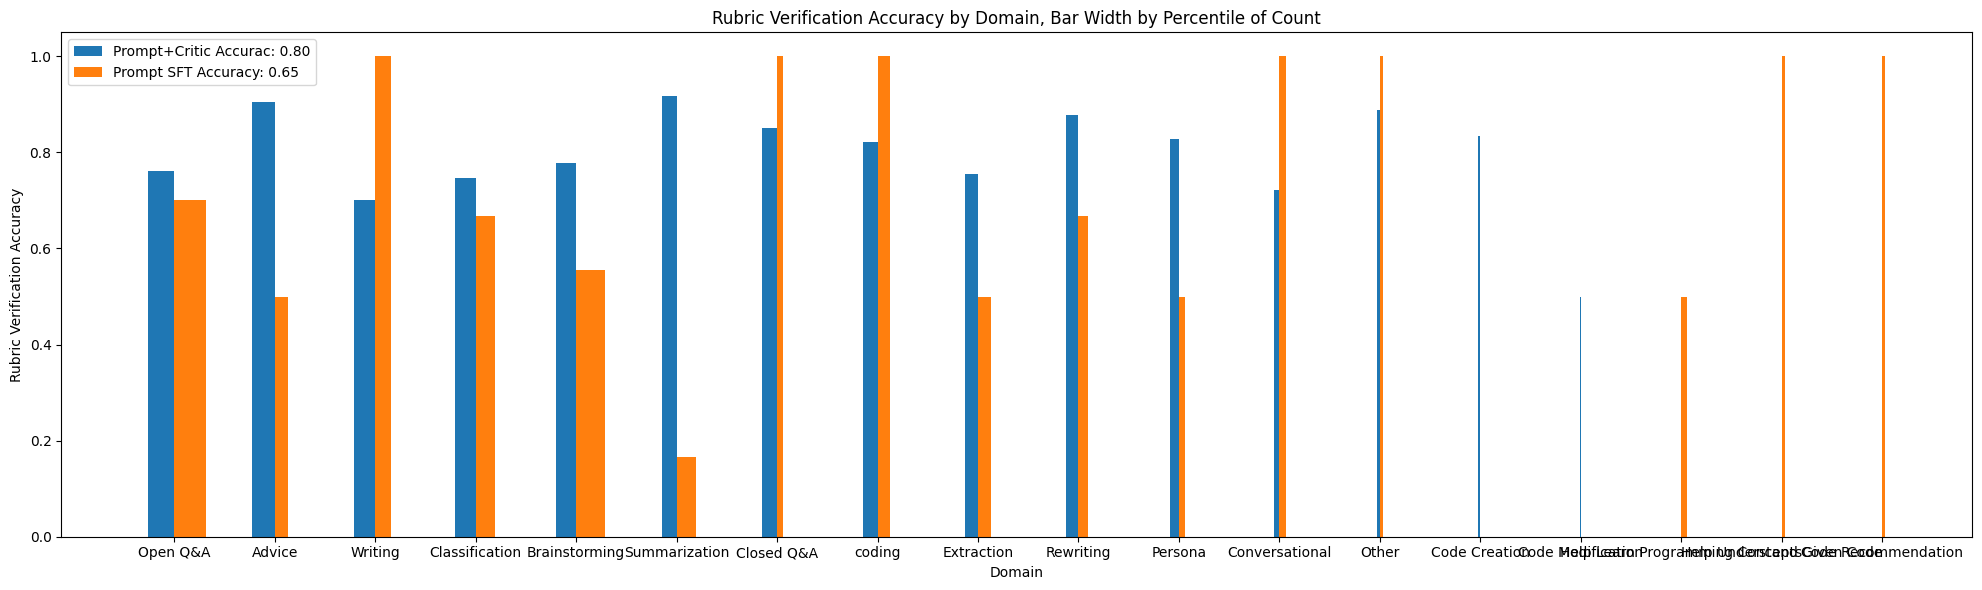

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df1 = result_df_ref
df2 = result_df
df1 = df1[df1['domain'] != 'ALL']
df2 = df2[df2['domain'] != 'ALL']

# Merge both dataframes on domain
merged_df = pd.merge(df1, df2, on='domain', suffixes=('_df1', '_df2'))

# Calculate percentiles for width scaling (you can adjust the percentile scaling as needed)
merged_df['percentile_width_df1'] = merged_df['count_df1'] / merged_df['count_df1'].sum()
merged_df['percentile_width_df2'] = merged_df['count_df2'] / merged_df['count_df2'].sum()

# Define bar positions
index = np.arange(len(merged_df))
bar_width_df1 = merged_df['percentile_width_df1'] * 2.0  # Scaling the width for better visualization
bar_width_df2 = merged_df['percentile_width_df2'] * 2.0

# Plotting
fig, ax = plt.subplots(figsize=(20, 6))

# Plot bars
bars1 = ax.bar(index - bar_width_df1 / 2, merged_df['accuracy_df1'], width=bar_width_df1, label='Prompt+Critic Accurac: 0.80', align='center')
bars2 = ax.bar(index + bar_width_df2 / 2, merged_df['accuracy_df2'], width=bar_width_df2, label='Prompt SFT Accuracy: 0.65', align='center')

# Labeling
ax.set_xlabel('Domain')
ax.set_ylabel('Rubric Verification Accuracy')
ax.set_title('Rubric Verification Accuracy by Domain, Bar Width by Percentile of Count')
ax.set_xticks(index)
ax.set_xticklabels(merged_df['domain'])
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import re, ast, json
def parse_verify(response: str) -> float | None:
    pattern = r"<rubrics\b[^>]*>(.*?)<\/rubrics>"

    m = re.search(pattern, response, re.DOTALL)
    if m:
        rubrics_content = m.group(1).strip()
        res = ast.literal_eval(rubrics_content)
        return json.dumps(res, indent=2)
    return None


response = """
<analysis>The query "Diamond League sounds like a pokemon game. Are there other leagues like this?" requires a casual response. The key requirements are:

1. **Similarity in Name**: Look for leagues with names that sound like they could be from a video game or entertainment context, similar to "Diamond League".

2. **Comparison**: The response should acknowledge or implicitly recognize the Diamond League's existence while introducing similar leagues in athletics.

3. **Limited Response**: The response must be concise and limited in nature (3 sentences as per query), mimicking casual chat dialogue.

4. **Existence**: Confirm if there are other athletic leagues or series with quirky or game-like sounding names.

These criteria ensure the answer addresses the playful nature of the question while providing useful information within the constraints provided.
</analysis>

<rubrics>
{
    "criterion_1": "The response includes leagues with names that could be perceived as playful or game-like.",
    "criterion_2": "The response hints at or directly acknowledges the existence of the Diamond League.",
    "criterion_3": "The response does not exceed 3 sentences in length.",
    "criterion_4": "Leagues introduced are relevant to athletics."
}
</rubrics>
"""

# parse_verify(response)

'{\n  "criterion_1": "The response includes leagues with names that could be perceived as playful or game-like.",\n  "criterion_2": "The response hints at or directly acknowledges the existence of the Diamond League.",\n  "criterion_3": "The response does not exceed 3 sentences in length.",\n  "criterion_4": "Leagues introduced are relevant to athletics."\n}'

In [ ]:

# import ast
# import json
# import logging
# import re
# from abc import ABC, abstractmethod
# from typing import Any

# import markdown

# from xlm.config import Config, configclass
# from xlm.posttrain.data import formatting
# from xlm.reward_client import RubricCriticRewardClient
# from xlm.utils import configure_logging


# from xlm.sampling_client import SamplingClient

# from xlm.reward_client import RubricCriticRewardClient

# from xlm.posttrain.data.preprocess.filter_custom import CustomFilter


# class VerifierRubricsFilter(CustomFilter):
#     """Removes verifier bad results according to synthetic rubrics."""
#     rubric_gen_templates: str
#     rubric_gen_model: str
#     rubric_verifier_model : str
#     rubric_gen_client: SamplingClient = None
#     verifier_client: RubricCriticRewardClient = None
#     max_retry: int = 2

#     def __post_init__(self):
#         self.rubric_threshold = 0.5
#         self.max_parallel = 512
#         self.max_retry = 2

#         # rubric_gen model
#         from xlm.posttrain.evals import rubric_proposer
#         self.rubric_gen_templates = rubric_proposer.RUBRIC_PROPOSER_PROMPT_V1 + rubric_proposer.RUBRIC_PROPOSER_PROMPT_no_response

#         self.rubric_gen_model = "v5l-1010-sft-full.yuchen.svc.kiy.x.ai"
#         self.rubric_gen_client = SamplingClient(oai_max_parallel=1, llama3_max_parallel=1024)
#         self.rubric_gen_client._grok_client.register_model(
#             model="rubric-gen-model",
#             model_address=self.rubric_gen_model,
#             max_parallel=self.max_parallel,
#         )
#         self.rubric_gen_sampling_args = {
#             "seed": 0,
#             "temperature": 1.0,
#             "top_p": 1.0,
#             "max_tokens": 4096,
#         }

#         # rubric verifier model
#         self.rubric_verifier_model = "v5l-1010-sft-full.yuchen.svc.kiy.x.ai"
#         self.verifier_version = "no_cot"
#         self.verifier_client = RubricCriticRewardClient(
#             address=self.rubric_verifier_model,
#             max_parallel=self.max_parallel,
#             verifier_version=self.verifier_version,
#         )

#     def rubrics_gen_message(self, messages: list[str]) -> list[str]:
#         # rubric_gen model
#         rubrics_msgs = messages[: -1]
#         query = rubrics_msgs[-1]
#         history = ""
#         if len(rubrics_msgs) > 1:
#             history = formatting.render_conversation(name="grok", messages=rubrics_msgs[:-1])
#             if history.endswith("<|separator|>"):
#                 history = history[: -len("<|separator|>")]
#         rubrics_gen_messages = [
#             {
#                 "role": "user",
#                 "content": self.rubric_gen_templates.format(
#                     history=history,
#                     prompt=query["content"],
#                     # critic=example["critic"],
#                     # response0=example["conversation0"][-1]["content"],
#                     # response1=example["conversation1"][-1]["content"],
#                 ),
#             }
#         ]
#         return rubrics_gen_messages

#     def parse_rubrics(self, response: str) -> float | None:
#         response = response.replace("*", "")
#         m = re.search(r"<rubrics\b[^>]*>(.*?)<\/rubrics>", response, re.DOTALL)
#         if m:
#             rubrics_content = m.group(1).strip()
#             if "```json" in rubrics_content:
#                 m = re.search(r"\s*```json\s*(.*?)\s*```", rubrics_content, re.DOTALL)
#                 if m:
#                     rubrics_content = m.group(1).strip()
#                 rubrics_content = rubrics_content.replace("```python", "").replace("```json", "").replace("```", "")
#             res = ast.literal_eval(rubrics_content)
#             return json.dumps(res, indent=2)
#         m = re.search(r"\s*```json\s*(.*?)\s*```", response, re.DOTALL)
#         if m:
#             res = m.group(1).strip()
#             res = res.replace("```json", "").replace("```", "")
#             res = ast.literal_eval(res)
#             return json.dumps(res, indent=2)
#         m = re.search(r"\{.*?\}", response, re.DOTALL)
#         if m:
#             res = ast.literal_eval(m.group())
#             return json.dumps(res, indent=2)
#         # else we just directly output res? it shall be json parsable?
#         return None

#     async def generate_rubrics(self, messages: list[dict[str, Any]]) -> dict[str, Any]:
#         idx = 0
#         answer = None
#         while idx < self.max_retry + 1:
#             response = await self.rubric_client.generate(
#                 model=self.rubric_gen_model, messages=messages, **self.rubric_gen_sampling_args
#             )
#             answer = self.parse_rubrics(response)
#             if answer is not None:
#                 break
#             idx += 1
#         return answer

#     async def verify_rubrics(self, verifier_msgs: list[str], rubrics: list[str] = []) -> float:
#         rubric_verifiers = await self.verifier_client.generate(messages=verifier_msgs, rubric_list=rubrics)
#         return rubric_verifiers

#     async def filter(self, message: str,  messages: list[str ] = None) -> bool:
#         rubrics = [] # list of str

#         rubrics_gen_messages = self.rubrics_gen_message(messages=messages)

#         rubrics = await self.generate_rubrics(rubrics_gen_messages)

#         rubrics_results_answers = await self.verify_rubrics(messages, rubrics=rubrics)

#         rubrics_len = len(rubrics)
#         reward = rubrics_results_answers["reward"]
#         if rubrics_len > 0:
#             return reward > self.rubric_threshold * rubrics_len
#         return True

#     def __repr__(self):
#         return f"Bad verifier results for: {self.role}"

# Rubric Filters 10/21

In [ ]:
import ast
import asyncio
import glob
import json
import logging
import os
import re
import traceback
from typing import Any
import pandas as pd

import uuid
from xlm.config import configclass
from xlm.posttrain import utils
from xlm.posttrain.data import formatting
from xlm.posttrain.evals.eval_base import SamplerEvalBase
from xlm.sampling_client import SamplingClient

In [ ]:
data_path = "/data/datasets/preferences-v2/mixture/surge1t10/train/part-00001-of-00067.parquet"
df_data = utils.read_df(glob.glob(data_path))


reading paths: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.29it/s]


In [ ]:
from xlm.posttrain.data.preprocess.filter_custom import VerifierRubricsFilter
rubric_filters = VerifierRubricsFilter(role="assistant")


[2024-10-18 00:58:16,355 W] [boxn-0:78741] sampling_client:1066: Expecting 1 or more API keys in the OPENAI_API_KEY environment variable, but got: None
[2024-10-18 00:58:16,356 W] [boxn-0:78741] sampling_client:871: Expecting 1 or more API keys in the ANTHROPIC_API_KEY environment variable, but got: None
[2024-10-18 00:58:16,356 W] [boxn-0:78741] sampling_client:740: Environment var `GEMINI_API_KEY` not set.
[2024-10-18 00:58:16,411 E] [boxn-0:78741] sampling_client:988: bedrock setup failed: The config profile (key0) could not be found
[2024-10-18 00:58:16,564 W] [boxn-0:78741] sampling_client:1874: Expecting 1 or more API keys in the XAI_API_KEY environment variable, but got: None
[2024-10-18 00:58:16,567 W] [boxn-0:78741] sampling_client:1066: Expecting 1 or more API keys in the OPENAI_API_KEY environment variable, but got: None
[2024-10-18 00:58:16,567 W] [boxn-0:78741] sampling_client:871: Expecting 1 or more API keys in the ANTHROPIC_API_KEY environment variable, but got: None
[2

In [ ]:
messages_examples = df_data['conversation0']
for i in range(10):
  messages = messages_examples[i].tolist()
  print(json.dumps(messages, indent=2))
  filter = await rubric_filters.filter(message=messages[-1], messages=messages)
  print(filter)

[
  {
    "content": "What are the differences in the types of pareto distributions? Which is most often used in actuarial science? ",
    "role": "user"
  },
  {
    "content": "Pareto distributions are continuous probability distributions that are often used to model heavy-tailed phenomena like income distribution, wealth distribution, sizes of cities, insurance claims, etc. There are several types of Pareto distributions, each with slightly different mathematical properties. Here are some main types:\n\n1. **Pareto Type I (The Classic Pareto Distribution)**:\n   - It is defined by the scale parameter (\u03b1 or xm) and shape parameter (\u03b1).\n   - Probability Density Function (PDF): \\(f(x) = \\frac{\\alpha x_m^{\\alpha}}{x^{\\alpha+1}}\\) for \\(x \\geq x_m\\)\n   - Cumulative Distribution Function (CDF): \\(F(x) = 1 - \\left(\\frac{x_m}{x}\\right)^\\alpha\\)\n\n2. **Pareto Type II (also known as Lomax Distribution)**:\n   - Adds a location parameter (\u03bc), shifting the distr

In [ ]:
# data_path = "/data/datasets/preferences-v2/mixture/grand_reward/train/part-00026-of-00067.parquet"
# pref_data = utils.read_df(glob.glob(data_path))

# pref_data


NameError: name 'utils' is not defined

In [ ]:
data_path = "/data/datasets/sft-data/staging/common_filter_081324_fix_cutoff_w_rubrics/custom_convos/part-00000-of-00001.parquet"
sft_data = utils.read_df(glob.glob(data_path))

reward_good = 0.5
bad_rows = []
good_rows = []
for idx, (_, row) in enumerate(sft_data.iterrows()):
  reward = row['metadata']['rubric_verifier']['reward']
  if reward and reward < reward_good:
    bad_rows.append(row)
  else:
    good_rows.append(row)


reading paths: 0it [00:00, ?it/s]


ValueError: No objects to concatenate

# Rubric Filter Analysis 10/22

In [ ]:
import os
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

INPUT_ROOT = "/data/datasets/sft-data/staging/common_filter_081324_fix_cutoff_w_rubrics"
INPUT_ROOT_SIDE =  "/data/datasets/sft-data/staging/common_filter_081324_fix_cutoff_w_rubrics_filtered_0_5"
OUTPUT_STATS_FILE = os.path.join(INPUT_ROOT, "stats.parquet")

def process_parquet_file(file_path):
    """Process a single parquet file to extract category, reward, rubrics, and conversation length data."""
    table = pq.read_table(file_path)
    df = table.to_pandas()

    # Ensure relevant columns exist
    if 'metadata' not in df:
        return None
    if 'domain' not in df:
        df['domain'] = 'UNKNOWN'

    # Extract relevant data
    df['reward'] = df['metadata'].apply(lambda x: x.get('rubric_verifier', {}).get('reward', None))
    df['rubrics'] = df['metadata'].apply(lambda x: len(x.get('rubric_verifier', {}).get('rubrics', [])))
    df['response_length'] = df['conversation'].apply(lambda x: len(x[-1]['content']) if len(x) > 0 else 0)

    # Filter out rows with no reward
    df = df.dropna(subset=['reward'])

    return df[['domain', 'reward', 'rubrics', 'response_length']]

def bucket_data(df):
    """Assign buckets based on 10 percentile buckets for reward, rubrics, and conversation length."""
    # Bucketing for conversation length
    df['length_bucket'] = pd.qcut(df['response_length'], q=10, labels=False, duplicates='drop')

    # Bucketing for rubrics
    df['rubrics_bucket'] = pd.qcut(df['rubrics'], q=10, labels=False, duplicates='drop')

    # Bucketing for rewards
    df['reward_bucket'] = pd.qcut(df['reward'], q=10, labels=False, duplicates='drop')

    return df

def get_bucket_boundaries(df):
    """Calculate the boundaries for each of the 10 percentile buckets."""
    boundaries = {
        'reward_boundaries': np.percentile(df['reward'].dropna(), [i * 10 for i in range(11)]),
        'rubrics_boundaries': np.percentile(df['rubrics'].dropna(), [i * 10 for i in range(11)]),
        'length_boundaries': np.percentile(df['response_length'].dropna(), [i * 10 for i in range(11)]),
    }

    # Drop duplicates from the boundaries
    boundaries['reward_boundaries'] = np.unique(boundaries['reward_boundaries'])
    boundaries['rubrics_boundaries'] = np.unique(boundaries['rubrics_boundaries'])
    boundaries['length_boundaries'] = np.unique(boundaries['length_boundaries'])

    return boundaries

def process_directory(input_root):
    """Process all parquet files in the input directory and collect data."""
    all_data = []

    for root, dirs, files in os.walk(input_root):
        for file in tqdm(files, desc="Processing files"):
            if file.endswith(".parquet"):
                file_path = os.path.join(root, file)
                df = process_parquet_file(file_path)
                if df is not None and not df.empty:
                    all_data.append(df)

    if all_data:
        combined_df = pd.concat(all_data)
        return combined_df
    return None

def calculate_average_and_count(df, bucket_column, value_column):
    """Calculate average and count for specified bucket column."""
    avg = df.groupby(bucket_column)[value_column].mean()
    count = df.groupby(bucket_column)[value_column].count()

    return avg, count

def plot_averages_and_counts(raw_df, boundaries):
    """Plot average rubrics and average rewards for each bucket in a 2x2 grid."""
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Average Rubrics and Average Reward per Bucket')

    # Average Rubrics per Reward Bucket
    avg_rubrics, count_rubrics = calculate_average_and_count(raw_df, 'reward_bucket', 'rubrics')
    bucket_labels = [f"[{boundaries['reward_boundaries'][i]:.2f}, {boundaries['reward_boundaries'][i + 1]:.2f})" for i in range(len(boundaries['reward_boundaries']) - 1)]

    bars = axs[0, 0].bar(bucket_labels, avg_rubrics, color='skyblue', edgecolor='black')
    axs[0, 0].set_xlabel('Reward Bucket Boundaries')
    axs[0, 0].set_ylabel('Average Rubrics')
    axs[0, 0].set_title('Average Rubrics per Reward Bucket')
    axs[0, 0].tick_params(axis='x', rotation=45)

    # Annotate counts on bars
    # for bar, count in zip(bars, count_rubrics):
    #     axs[0, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
    #                    ha='center', va='bottom')

    # Average Rubrics per Conversation Length Bucket
    avg_rubrics_length, count_rubrics_length = calculate_average_and_count(raw_df, 'length_bucket', 'rubrics')
    bucket_labels_length = [f"[{boundaries['length_boundaries'][i]:.2f}, {boundaries['length_boundaries'][i + 1]:.2f})" for i in range(len(boundaries['length_boundaries']) - 1)]

    bars_length = axs[0, 1].bar(bucket_labels_length, avg_rubrics_length, color='skyblue', edgecolor='black')
    axs[0, 1].set_xlabel('Response Length Bucket Boundaries')
    axs[0, 1].set_ylabel('Average Rubrics')
    axs[0, 1].set_title('Average Rubrics per Length Bucket')
    axs[0, 1].tick_params(axis='x', rotation=45)

    # Annotate counts on bars
    # for bar, count in zip(bars_length, count_rubrics_length):
    #     axs[0, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
    #                    ha='center', va='bottom')

    # Average Reward per Rubrics Bucket
    avg_reward, count_reward = calculate_average_and_count(raw_df, 'rubrics_bucket', 'reward')
    bucket_labels_rubrics = [f"[{boundaries['rubrics_boundaries'][i]:.2f}, {boundaries['rubrics_boundaries'][i + 1]:.2f})" for i in range(len(boundaries['rubrics_boundaries']) - 1)]

    bars_rubrics = axs[1, 0].bar(bucket_labels_rubrics, avg_reward, color='skyblue', edgecolor='black')
    axs[1, 0].set_xlabel('Rubrics Bucket Boundaries')
    axs[1, 0].set_ylabel('Average Reward')
    axs[1, 0].set_title('Average Reward per Rubrics Bucket')
    axs[1, 0].tick_params(axis='x', rotation=45)

    # Annotate counts on bars
    # for bar, count in zip(bars_rubrics, count_reward):
    #     axs[1, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
    #                    ha='center', va='bottom')

    # Average Reward per Conversation Length Bucket
    avg_reward_length, count_reward_length = calculate_average_and_count(raw_df, 'length_bucket', 'reward')

    bars_length_reward = axs[1, 1].bar(bucket_labels_length, avg_reward_length, color='skyblue', edgecolor='black')
    axs[1, 1].set_xlabel('Response Length Bucket Boundaries')
    axs[1, 1].set_ylabel('Average Reward')
    axs[1, 1].set_title('Average Reward per Length Bucket')
    axs[1, 1].tick_params(axis='x', rotation=45)

    # Annotate counts on bars
    # for bar, count in zip(bars_length_reward, count_reward_length):
    #     axs[1, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
    #                    ha='center', va='bottom')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def main():
    # Process the directory and get the raw DataFrame
    raw_df = process_directory(INPUT_ROOT)

    if raw_df is not None:
        # Bucket the data
        raw_df = bucket_data(raw_df)

        # Save the raw DataFrame to Parquet for further analysis
        raw_df.to_parquet(OUTPUT_STATS_FILE, index=False)
        print(f"Raw DataFrame saved to {OUTPUT_STATS_FILE}")

        # Get bucket boundaries
        boundaries = get_bucket_boundaries(raw_df)
        print("Bucket Boundaries:", boundaries)

        # Generate plots
        plot_averages_and_counts(raw_df, boundaries)

    else:
        print("No valid data found.")

if __name__ == '__main__':
    main()

In [ ]:
INPUT_ROOT_SIDE =  "/data/datasets/sft-data/staging/common_filter_081324_fix_cutoff_w_rubrics_filtered_0_8"

def bucket_data_with_boundaries(df, boundaries):
    """Assign buckets based on pre-calculated boundaries for reward, rubrics, and conversation length."""
    # Bucketing for conversation length
    df['length_bucket'] = pd.cut(df['response_length'], bins=boundaries['length_boundaries'], labels=False, include_lowest=True)

    # Bucketing for rubrics
    df['rubrics_bucket'] = pd.cut(df['rubrics'], bins=boundaries['rubrics_boundaries'], labels=False, include_lowest=True)

    # Bucketing for rewards
    df['reward_bucket'] = pd.cut(df['reward'], bins=boundaries['reward_boundaries'], labels=False, include_lowest=True)

    return df

def plot_averages_and_counts_side_by_side(df1, df2, boundaries):
    """Plot average rubrics and rewards for both datasets in a side-by-side comparison, labeled as 'Partial' and 'Partial+Filter'."""
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Comparison of Average Rubrics and Average Reward per Bucket (Partial vs. Partial+Filter)')

    # Labels for buckets
    reward_labels = [f"[{boundaries['reward_boundaries'][i]:.2f}, {boundaries['reward_boundaries'][i + 1]:.2f})" for i in range(len(boundaries['reward_boundaries']) - 1)]
    length_labels = [f"[{boundaries['length_boundaries'][i]:.2f}, {boundaries['length_boundaries'][i + 1]:.2f})" for i in range(len(boundaries['length_boundaries']) - 1)]
    rubrics_labels = [f"[{boundaries['rubrics_boundaries'][i]:.2f}, {boundaries['rubrics_boundaries'][i + 1]:.2f})" for i in range(len(boundaries['rubrics_boundaries']) - 1)]

    bar_width = 0.4  # Width of each bar
    x = np.arange(len(reward_labels))  # The label locations

    # Average Rubrics per Reward Bucket for both datasets
    avg_rubrics1, _ = calculate_average_and_count(df1, 'reward_bucket', 'rubrics')
    avg_rubrics2, _ = calculate_average_and_count(df2, 'reward_bucket', 'rubrics')

    axs[0, 0].bar(x - bar_width / 2, avg_rubrics1, width=bar_width, label='Partial', color='skyblue', edgecolor='black')
    axs[0, 0].bar(x + bar_width / 2, avg_rubrics2, width=bar_width, label='Partial+Filter', color='orange', edgecolor='black', alpha=0.7)
    axs[0, 0].set_xticks(x)
    axs[0, 0].set_xticklabels(reward_labels, rotation=45)
    axs[0, 0].set_xlabel('Reward Bucket Boundaries')
    axs[0, 0].set_ylabel('Average Rubrics')
    axs[0, 0].set_title('Average Rubrics per Reward Bucket')
    axs[0, 0].legend()

    # Average Rubrics per Length Bucket for both datasets
    avg_rubrics_length1, _ = calculate_average_and_count(df1, 'length_bucket', 'rubrics')
    avg_rubrics_length2, _ = calculate_average_and_count(df2, 'length_bucket', 'rubrics')

    x = np.arange(len(length_labels))  # Update x-axis positions
    axs[0, 1].bar(x - bar_width / 2, avg_rubrics_length1, width=bar_width, label='Partial', color='skyblue', edgecolor='black')
    axs[0, 1].bar(x + bar_width / 2, avg_rubrics_length2, width=bar_width, label='Partial+Filter', color='orange', edgecolor='black', alpha=0.7)
    axs[0, 1].set_xticks(x)
    axs[0, 1].set_xticklabels(length_labels, rotation=45)
    axs[0, 1].set_xlabel('Response Length Bucket Boundaries')
    axs[0, 1].set_ylabel('Average Rubrics')
    axs[0, 1].set_title('Average Rubrics per Length Bucket')
    axs[0, 1].legend()

    # Average Reward per Rubrics Bucket for both datasets
    avg_reward1, _ = calculate_average_and_count(df1, 'rubrics_bucket', 'reward')
    avg_reward2, _ = calculate_average_and_count(df2, 'rubrics_bucket', 'reward')

    x = np.arange(len(rubrics_labels))  # Update x-axis positions
    axs[1, 0].bar(x - bar_width / 2, avg_reward1, width=bar_width, label='Partial', color='skyblue', edgecolor='black')
    axs[1, 0].bar(x + bar_width / 2, avg_reward2, width=bar_width, label='Partial+Filter', color='orange', edgecolor='black', alpha=0.7)
    axs[1, 0].set_xticks(x)
    axs[1, 0].set_xticklabels(rubrics_labels, rotation=45)
    axs[1, 0].set_xlabel('Rubrics Bucket Boundaries')
    axs[1, 0].set_ylabel('Average Reward')
    axs[1, 0].set_title('Average Reward per Rubrics Bucket')
    axs[1, 0].legend()

    # Average Reward per Length Bucket for both datasets
    avg_reward_length1, _ = calculate_average_and_count(df1, 'length_bucket', 'reward')
    avg_reward_length2, _ = calculate_average_and_count(df2, 'length_bucket', 'reward')

    x = np.arange(len(length_labels))  # Reuse length labels for x-axis
    axs[1, 1].bar(x - bar_width / 2, avg_reward_length1, width=bar_width, label='Partial', color='skyblue', edgecolor='black')
    axs[1, 1].bar(x + bar_width / 2, avg_reward_length2, width=bar_width, label='Partial+Filter', color='orange', edgecolor='black', alpha=0.7)
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(length_labels, rotation=45)
    axs[1, 1].set_xlabel('Response Length Bucket Boundaries')
    axs[1, 1].set_ylabel('Average Reward')
    axs[1, 1].set_title('Average Reward per Length Bucket')
    axs[1, 1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def main():
    # Process the main directory
    raw_df1 = process_directory(INPUT_ROOT)

    # Process the secondary directory
    raw_df2 = process_directory(INPUT_ROOT_SIDE)

    if raw_df1 is not None and raw_df2 is not None:
        # Get bucket boundaries from the main dataset
        boundaries = get_bucket_boundaries(raw_df1)

        # Bucket both datasets using the same boundaries
        raw_df1 = bucket_data_with_boundaries(raw_df1, boundaries)
        raw_df2 = bucket_data_with_boundaries(raw_df2, boundaries)

        # Save the raw DataFrame to Parquet for further analysis
        raw_df1.to_parquet(OUTPUT_STATS_FILE, index=False)
        print(f"Raw DataFrame saved to {OUTPUT_STATS_FILE}")

        # Plot the results side by side for both datasets
        plot_averages_and_counts_side_by_side(raw_df1, raw_df2, boundaries)

    else:
        print("No valid data found in one or both directories.")

if __name__ == '__main__':
    main()

In [179]:
import os
import pyarrow.parquet as pq
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

input_folder = "/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics"

total_rows = 0
total_files = 0
total_rows_with_rubrics = 0
total_rows_with_rubris_null = 0
all_rows_rewards = {}
empty_wrong_files = []

# Traverse the directory structure
for dir in os.listdir(input_folder):
    input_path = os.path.join(input_folder, dir)
    total_files += 1
    try:
      if len(os.listdir(input_path)) == 0:
        print("!!!!EMPTY/WRONG", input_path)
        empty_wrong_files += [dir]
        continue
      print(input_path)
      data = utils.read_df(glob.glob(input_path + "/*.parquet"))
      all_rows_rewards[dir]  = []
      total_rows += data.shape[0]
      for _, d in data["rubric_metadata"].items():
          r = None
          if d:
            r = d.get("rubric_verifier", {}).get("reward", None)
            # print(f"{d=} {r=} {r is None}")
            if r is not None:
              all_rows_rewards[dir] += [r]
          total_rows_with_rubrics += r is not None
          total_rows_with_rubris_null += r is None
      print(f"\n>>>{total_files=} {total_rows=} {total_rows_with_rubrics=} {total_rows_with_rubris_null=}")
    except Exception as e :
      print("Exception: ", e)
      empty_wrong_files += [dir]

total_rows_with_rubrics_more_than_05= sum(v> 0.5 for v in rewards_all)
print(f"\nFINAL {total_files=} {total_rows=} {total_rows_with_rubrics=} {total_rows_with_rubris_null=} {total_rows_with_rubrics_more_than_05=} ")
print(empty_wrong_files)


/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/meta-knowledge_train_sft


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 190.08it/s]



>>>total_files=1 total_rows=58 total_rows_with_rubrics=58 total_rows_with_rubris_null=0
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/custom_convos-v2


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 147.79it/s]



>>>total_files=2 total_rows=163 total_rows_with_rubrics=163 total_rows_with_rubris_null=0
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/af_top2_reward_math


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.98it/s]



>>>total_files=3 total_rows=13880 total_rows_with_rubrics=13519 total_rows_with_rubris_null=361
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/mapcf_claude_40k


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.41it/s]



>>>total_files=4 total_rows=19350 total_rows_with_rubrics=13613 total_rows_with_rubris_null=5737
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/arc_title_snippet_sum_lex_pass_rand


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.44it/s]



>>>total_files=5 total_rows=19484 total_rows_with_rubrics=13742 total_rows_with_rubris_null=5742
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/q0220_top10_arc_dates_snippet_title_fulltext_reversedateorder_rand_pass


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.42it/s]



>>>total_files=6 total_rows=19517 total_rows_with_rubrics=13762 total_rows_with_rubris_null=5755
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/q0209_top10_arc_dates_snippet_title_fulltext_reversedateorder_rand_pass


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.70it/s]



>>>total_files=7 total_rows=19577 total_rows_with_rubrics=13795 total_rows_with_rubris_null=5782
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/lepton_chunk_embedder_pass_rand


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.54it/s]



>>>total_files=8 total_rows=19788 total_rows_with_rubrics=13892 total_rows_with_rubris_null=5896
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/multiturn_25k_d_f_turn_6_20


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]



>>>total_files=9 total_rows=24234 total_rows_with_rubrics=18201 total_rows_with_rubris_null=6033
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/ultrafeed_wizardlm


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.12it/s]



>>>total_files=10 total_rows=25620 total_rows_with_rubrics=19558 total_rows_with_rubris_null=6062
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/ja_0404


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]



>>>total_files=11 total_rows=30554 total_rows_with_rubrics=24480 total_rows_with_rubris_null=6074
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/leetcode_devins


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.30it/s]



>>>total_files=12 total_rows=32854 total_rows_with_rubrics=26454 total_rows_with_rubris_null=6400
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/openchat_xai


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.36it/s]



>>>total_files=13 total_rows=33553 total_rows_with_rubrics=27141 total_rows_with_rubris_null=6412
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/lepton_chunk_rejector_pass_rand


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.71it/s]



>>>total_files=14 total_rows=33766 total_rows_with_rubrics=27260 total_rows_with_rubris_null=6506
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/leetcode_direct


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.18it/s]



>>>total_files=15 total_rows=37259 total_rows_with_rubrics=27260 total_rows_with_rubris_null=9999
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/ultrafeed_sharegpt


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.16it/s]



>>>total_files=16 total_rows=40120 total_rows_with_rubrics=27260 total_rows_with_rubris_null=12860
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/q0220_bing2_top10_arc_dates_snippet_title_fulltext_reversedateorder_rand_pass


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.98it/s]



>>>total_files=17 total_rows=40154 total_rows_with_rubrics=27260 total_rows_with_rubris_null=12894
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/lmsys_data_share_vibes_0809


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.25it/s]



>>>total_files=18 total_rows=40170 total_rows_with_rubrics=27260 total_rows_with_rubris_null=12910
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/4o_outputs_37k_filtered_d_f


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.70it/s]



>>>total_files=19 total_rows=69493 total_rows_with_rubrics=56398 total_rows_with_rubris_null=13095
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/chatgpt_exports_all


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.46it/s]



>>>total_files=20 total_rows=70177 total_rows_with_rubrics=56708 total_rows_with_rubris_null=13469
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/apps_cld_refresh


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.73it/s]



>>>total_files=21 total_rows=78118 total_rows_with_rubrics=64452 total_rows_with_rubris_null=13666
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/xai_instruct


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.88it/s]



>>>total_files=22 total_rows=96184 total_rows_with_rubrics=82368 total_rows_with_rubris_null=13816
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/bigcodebench_direct


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.17it/s]



>>>total_files=23 total_rows=97293 total_rows_with_rubrics=83426 total_rows_with_rubris_null=13867
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/stacex_vendor_lmsyslike_top20k_proc


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.13it/s]



>>>total_files=24 total_rows=102763 total_rows_with_rubrics=83520 total_rows_with_rubris_null=19243
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/lepton_sum_gpt4_pass_rand


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.20it/s]



>>>total_files=25 total_rows=102942 total_rows_with_rubrics=83694 total_rows_with_rubris_null=19248
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/claude_on_removed_prompts


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.53it/s]



>>>total_files=26 total_rows=114431 total_rows_with_rubrics=94971 total_rows_with_rubris_null=19460
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/wildchat_ja


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 129.92it/s]



>>>total_files=27 total_rows=114597 total_rows_with_rubrics=95133 total_rows_with_rubris_null=19464
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/qwen_filtered_synthetic_math1


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.80it/s]



>>>total_files=28 total_rows=184597 total_rows_with_rubrics=163669 total_rows_with_rubris_null=20928
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/capybara


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]



>>>total_files=29 total_rows=191235 total_rows_with_rubrics=170293 total_rows_with_rubris_null=20942
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/strawberry-v3


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.98it/s]



>>>total_files=30 total_rows=191439 total_rows_with_rubrics=170497 total_rows_with_rubris_null=20942
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/dry_run_mbpp


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.77it/s]



>>>total_files=31 total_rows=196909 total_rows_with_rubrics=170591 total_rows_with_rubris_null=26318
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/qwen_filtered_gsm8k1


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.63it/s]



>>>total_files=32 total_rows=202471 total_rows_with_rubrics=176153 total_rows_with_rubris_null=26318
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/qwen_filtered_olympiads1


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.09it/s]



>>>total_files=33 total_rows=232471 total_rows_with_rubrics=205237 total_rows_with_rubris_null=27234
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/q0209_top10_lepton_dates_snippet_title_fulltext_rand_pass


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 118.75it/s]



>>>total_files=34 total_rows=232498 total_rows_with_rubrics=205253 total_rows_with_rubris_null=27245
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/wildchat_imperative


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.38it/s]



>>>total_files=35 total_rows=232873 total_rows_with_rubrics=205626 total_rows_with_rubris_null=27247
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/sft_proc_k4


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.89it/s]



>>>total_files=36 total_rows=260061 total_rows_with_rubrics=232295 total_rows_with_rubris_null=27766
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/ver-v1-7_distilled_no_refusal


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.21it/s]



>>>total_files=37 total_rows=261274 total_rows_with_rubrics=232684 total_rows_with_rubris_null=28590
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/qwen_filtered_math1


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.77it/s]



>>>total_files=38 total_rows=268140 total_rows_with_rubrics=239517 total_rows_with_rubris_null=28623
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/arc_title_snippet_sum_gpt4_pass_rand


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.43it/s]



>>>total_files=39 total_rows=268361 total_rows_with_rubrics=239725 total_rows_with_rubris_null=28636
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/identity_multilingual_singleturn


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.93it/s]



>>>total_files=40 total_rows=274395 total_rows_with_rubrics=245658 total_rows_with_rubris_null=28737
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/identity_grok_multiturn-v2


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.43it/s]



>>>total_files=41 total_rows=274899 total_rows_with_rubrics=246161 total_rows_with_rubris_null=28738
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/4o_output_cba_24k_d_f


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]



>>>total_files=42 total_rows=296259 total_rows_with_rubrics=267254 total_rows_with_rubris_null=29005
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/sft_mixture_misgender_with_rag_subsampled


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 198.90it/s]



>>>total_files=43 total_rows=296379 total_rows_with_rubrics=267370 total_rows_with_rubris_null=29009
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/complex_query_single_doc_single_turn_1013


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]



>>>total_files=44 total_rows=301849 total_rows_with_rubrics=267464 total_rows_with_rubris_null=34385
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/lepton_sum_gpt4_old_pass_rand


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 72.11it/s]



>>>total_files=45 total_rows=302019 total_rows_with_rubrics=267565 total_rows_with_rubris_null=34454
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/q0220_para_title_snippet_sum_gpt4_pass_rand


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 186.44it/s]



>>>total_files=46 total_rows=302056 total_rows_with_rubrics=267585 total_rows_with_rubris_null=34471
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/cc_selfrepair


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]



>>>total_files=47 total_rows=306743 total_rows_with_rubrics=272219 total_rows_with_rubris_null=34524
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/cnbc_v2_ge4


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 139.52it/s]



>>>total_files=48 total_rows=306901 total_rows_with_rubrics=272377 total_rows_with_rubris_null=34524
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/arc_title_snippet_sum_tex_pass_rand


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.54it/s]



>>>total_files=49 total_rows=306997 total_rows_with_rubrics=272472 total_rows_with_rubris_null=34525
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/q0209_lepton_fulltext_rand_pass


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 118.59it/s]



>>>total_files=50 total_rows=307020 total_rows_with_rubrics=272480 total_rows_with_rubris_null=34540
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/scale_prod_1to7_amazing


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]



>>>total_files=51 total_rows=307816 total_rows_with_rubrics=273242 total_rows_with_rubris_null=34574
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/col_r_on_competitive_coding_proc


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.95it/s]



>>>total_files=52 total_rows=309132 total_rows_with_rubrics=274555 total_rows_with_rubris_null=34577
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/synthetic_humaneval_cot


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.93it/s]



>>>total_files=53 total_rows=313573 total_rows_with_rubrics=278721 total_rows_with_rubris_null=34852
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/format_sft_lmsys


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.77it/s]



>>>total_files=54 total_rows=319043 total_rows_with_rubrics=278815 total_rows_with_rubris_null=40228
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/lmsys_xai


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.90it/s]



>>>total_files=55 total_rows=320464 total_rows_with_rubrics=280230 total_rows_with_rubris_null=40234
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/simple_query_single_doc_multi_turn_0905


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.49it/s]



>>>total_files=56 total_rows=325934 total_rows_with_rubrics=280324 total_rows_with_rubris_null=45610
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/vibe_decimal


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 101.25it/s]



>>>total_files=57 total_rows=326600 total_rows_with_rubrics=280990 total_rows_with_rubris_null=45610
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/mbpp_star


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.65it/s]



>>>total_files=58 total_rows=329955 total_rows_with_rubrics=284343 total_rows_with_rubris_null=45612
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/vibes_kenya_proc


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 311.87it/s]



>>>total_files=59 total_rows=329965 total_rows_with_rubrics=284353 total_rows_with_rubris_null=45612
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/xai_instruct_0426


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.62it/s]



>>>total_files=60 total_rows=339965 total_rows_with_rubrics=294098 total_rows_with_rubris_null=45867
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/ko_ja_de_4o_filtered_flang


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.55it/s]



>>>total_files=61 total_rows=371315 total_rows_with_rubrics=325172 total_rows_with_rubris_null=46143
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/identity_grok-v2


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.95it/s]



>>>total_files=62 total_rows=372205 total_rows_with_rubrics=325172 total_rows_with_rubris_null=47033
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/q0220_para_title_snippet_sum_tex_pass_rand


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 108.73it/s]



>>>total_files=63 total_rows=372231 total_rows_with_rubrics=325172 total_rows_with_rubris_null=47059
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/q0209_top10_lepton_fulltext_rand_pass


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.33it/s]



>>>total_files=64 total_rows=372263 total_rows_with_rubrics=325172 total_rows_with_rubris_null=47091
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/grok_lmsys_wildchat_longalign_241021_gt8k


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]



>>>total_files=65 total_rows=377144 total_rows_with_rubrics=325172 total_rows_with_rubris_null=51972
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/q0209_top10_lepton_dates_fulltext_rand_pass


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 86.80it/s]



>>>total_files=66 total_rows=377182 total_rows_with_rubrics=325172 total_rows_with_rubris_null=52010
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/wildchat_requirements


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.41it/s]



>>>total_files=67 total_rows=377556 total_rows_with_rubrics=325527 total_rows_with_rubris_null=52029
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/humanity_vibes_0809


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 211.75it/s]



>>>total_files=68 total_rows=377694 total_rows_with_rubrics=325527 total_rows_with_rubris_null=52167
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/humanity_vibes_proc


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.08it/s]



>>>total_files=69 total_rows=379967 total_rows_with_rubrics=325527 total_rows_with_rubris_null=54440
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/selfexec_p25


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.77it/s]



>>>total_files=70 total_rows=385437 total_rows_with_rubrics=325621 total_rows_with_rubris_null=59816
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/wildchat_multiturn


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]



>>>total_files=71 total_rows=399644 total_rows_with_rubrics=330837 total_rows_with_rubris_null=68807
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/alpaca_exclude_rewrite


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]



>>>total_files=72 total_rows=443290 total_rows_with_rubrics=374306 total_rows_with_rubris_null=68984
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/claude3_5_codegen


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.53it/s]



>>>total_files=73 total_rows=448760 total_rows_with_rubrics=374400 total_rows_with_rubris_null=74360
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/multi_turn_gpt_50-100_filter_filterrefusal_f


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]



>>>total_files=74 total_rows=452547 total_rows_with_rubrics=378104 total_rows_with_rubris_null=74443
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/identity_multilingual_multiturn


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]



>>>total_files=75 total_rows=457763 total_rows_with_rubrics=383263 total_rows_with_rubris_null=74500
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/multi_turn_gpt_0-50_filter_filterrefusal_f


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]



>>>total_files=76 total_rows=461599 total_rows_with_rubrics=387028 total_rows_with_rubris_null=74571
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/ambiguous_query_train_sft


reading paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 204.62it/s]



>>>total_files=77 total_rows=461633 total_rows_with_rubrics=387061 total_rows_with_rubris_null=74572
/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/qwen_filtered_aops_forum1


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.17it/s]


>>>total_files=78 total_rows=467103 total_rows_with_rubrics=392336 total_rows_with_rubris_null=74767

FINAL total_files=78 total_rows=467103 total_rows_with_rubrics=392336 total_rows_with_rubris_null=74767 total_rows_with_rubrics_more_than_05=200267 
[]


In [178]:
rewards_all = sum([v for v in all_rows_rewards.values() if v is not None], [])
print(len(rewards_all))
print(sum(v> 0.5 for v in rewards_all if v is not None))

392336
200267


In [163]:
import shutil

ref_folder = "/data/datasets/sft-data/staging/common_filter_102924_fix_cutoff_w_rubrics_repetition_redone/"
ref_folder = "/data/yuchen/bk_data"
output_folder = "/data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics"

for m in empty_files:
  path_ref = ref_folder + "/" + m
  path_output = output_folder +"/" + m
  print("\n", path_ref, path_output)
  if len(os.listdir(path_ref)) > 0:
    # if os.path.exists(path_output):
    #     print("backup the folder first", path_output)
    #     shutil.move(path_output, "/data/yuchen/bk_data/")
    df = utils.read_df(glob.glob(input_path + "/*.parquet"))
    # df = df.drop_duplicates([id])

    # if "rubric_metadata" in df.columns:
    #   print("\n already exists in columsn ",df.columns.tolist())

    #   shutil.copytree(path_ref, path_output)
    # else:
    df['rubric_metadata'] = df['metadata']
    df = df.drop(columns=['metadata'])
    print(df.columns.tolist(), path_output)
    utils.df_to_parquet(df, path_output)


['mapcf_claude_40k', 'stacex_vendor_lmsyslike_top20k_proc', 'dry_run_mbpp', 'complex_query_single_doc_single_turn_1013', 'format_sft_lmsys', 'simple_query_single_doc_multi_turn_0905', 'selfexec_p25', 'claude3_5_codegen']

 /data/yuchen/bk_data/mapcf_claude_40k /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/mapcf_claude_40k


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.88it/s]


['prompt', 'gt_solution', 'pred_solution', 'correct', 'id', 'conversation', 'conversation_str', 'repetitive/reasoning', 'repetitive/label', 'domain', 'rubric_metadata'] /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/mapcf_claude_40k


storing df as parquets: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]



 /data/yuchen/bk_data/stacex_vendor_lmsyslike_top20k_proc /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/stacex_vendor_lmsyslike_top20k_proc


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.55it/s]


['prompt', 'gt_solution', 'pred_solution', 'correct', 'id', 'conversation', 'conversation_str', 'repetitive/reasoning', 'repetitive/label', 'domain', 'rubric_metadata'] /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/stacex_vendor_lmsyslike_top20k_proc


storing df as parquets: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]



 /data/yuchen/bk_data/dry_run_mbpp /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/dry_run_mbpp


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.68it/s]


['prompt', 'gt_solution', 'pred_solution', 'correct', 'id', 'conversation', 'conversation_str', 'repetitive/reasoning', 'repetitive/label', 'domain', 'rubric_metadata'] /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/dry_run_mbpp


storing df as parquets: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]



 /data/yuchen/bk_data/complex_query_single_doc_single_turn_1013 /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/complex_query_single_doc_single_turn_1013


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.39it/s]


['prompt', 'gt_solution', 'pred_solution', 'correct', 'id', 'conversation', 'conversation_str', 'repetitive/reasoning', 'repetitive/label', 'domain', 'rubric_metadata'] /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/complex_query_single_doc_single_turn_1013


storing df as parquets: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]



 /data/yuchen/bk_data/format_sft_lmsys /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/format_sft_lmsys


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.93it/s]


['prompt', 'gt_solution', 'pred_solution', 'correct', 'id', 'conversation', 'conversation_str', 'repetitive/reasoning', 'repetitive/label', 'domain', 'rubric_metadata'] /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/format_sft_lmsys


storing df as parquets: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]



 /data/yuchen/bk_data/simple_query_single_doc_multi_turn_0905 /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/simple_query_single_doc_multi_turn_0905


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.16it/s]


['prompt', 'gt_solution', 'pred_solution', 'correct', 'id', 'conversation', 'conversation_str', 'repetitive/reasoning', 'repetitive/label', 'domain', 'rubric_metadata'] /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/simple_query_single_doc_multi_turn_0905


storing df as parquets: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]



 /data/yuchen/bk_data/selfexec_p25 /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/selfexec_p25


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.07it/s]


['prompt', 'gt_solution', 'pred_solution', 'correct', 'id', 'conversation', 'conversation_str', 'repetitive/reasoning', 'repetitive/label', 'domain', 'rubric_metadata'] /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/selfexec_p25


storing df as parquets: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]



 /data/yuchen/bk_data/claude3_5_codegen /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/claude3_5_codegen


reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.02it/s]


['prompt', 'gt_solution', 'pred_solution', 'correct', 'id', 'conversation', 'conversation_str', 'repetitive/reasoning', 'repetitive/label', 'domain', 'rubric_metadata'] /data/datasets/sft-data/staging/common_filter_110124_tmp_rubrics/claude3_5_codegen


storing df as parquets: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


In [ ]:
from functools import reduce

eval_results_1 = json.load(open("/data/evals/yuchen/gifeval/raw/v5l-cutoff-partial-sglang.yuchen.svc.max.x.ai/2024-10-23-060441/metrics.json"))
# eval_results_2 = json.load(open("/data/evals/yuchen/gifeval/raw/v5l-cutoff-partial-filter05-sglang.yuchen.svc.max.x.ai/2024-10-23-061006/metrics.json"))
eval_results_2 = json.load(open("/data/evals/yuchen/gifeval/raw/v5l-cutoff-partial-filter08-sglang.yuchen.svc.max.x.ai/2024-10-23-085555/metrics.json"))

eval_results_by_cat = lambda eval_results, by_cat: reduce(
  lambda x, y: {**x, **y},
  [
   {'gifeval' + ":" + m + "_" + k.replace(" (exclude tie)", ""): float(v[:v.find("(")]) for k, v in kv.items() if 'win_rate_by_' in k }
   for m, kv in eval_results[by_cat].items()
  ]
)
by = 'by_source'
by = 'by_category'
eval_results_1_by_cat = eval_results_by_cat(eval_results_1, by)
eval_results_2_by_cat = eval_results_by_cat(eval_results_2, by)

data = [ {'metric': k, 'partial': eval_results_1_by_cat[k] ,  'partial_filter08': eval_results_2_by_cat[k]}  for k  in eval_results_1_by_cat]


df = pd.DataFrame(data)

df

,metric,partial,partial_filter08
0,gifeval:Advice_win_rate_by_label,55.31,50.71
1,gifeval:Advice_win_rate_by_score,46.22,39.11
2,gifeval:Brainstorming_win_rate_by_label,47.69,44.73
3,gifeval:Brainstorming_win_rate_by_score,44.00,44.00
4,gifeval:Classification_win_rate_by_label,45.39,35.86
5,gifeval:Classification_win_rate_by_score,43.64,38.91
6,gifeval:Closed QA_win_rate_by_label,37.88,29.59
7,gifeval:Closed QA_win_rate_by_score,48.44,40.44
8,gifeval:Conversational_win_rate_by_label,27.99,28.14
9,gifeval:Conversational_win_rate_by_score,37.33,41.33


# Surge preference data 10/25




In [ ]:
fine_grained_output = json.load(open("/data/datasets/preferences-v2/surge/raw/Fine-Grained Outcomes #2 - 2024-10-08 - training.json"))

In [ ]:
import sys, os
sys.path.append(os.path.expanduser('~/xai/datasets/spark/preference/'))
from scratch.surge import Surge

file_name = 'general_2'
file_path = 'RLHF - General - Batch 2.json'

sdata = SurgeRenew(
    name=file_name.replace("surge_", "surge_finegrain_"),
    path_glob=f"/data/datasets/preferences-v2/surge/{file_path}",
    is_confident=False,
    is_hard=False,
    is_aspect=True,
).raw(regenerate_if_found=True).filtered()


output_path = RAW_PATH / sdata.name
data = pd.read_parquet(output_path / "part-00000-of-00001.parquet")
data

NameError: name 'SurgeRenew' is not defined

In [ ]:
data['quality_rating_B']

0        4.0
1     -100.0
2        2.0
3     -100.0
4     -100.0
       ...  
258      4.0
259      2.0
260   -100.0
261   -100.0
262      5.0
Name: quality_rating_B, Length: 263, dtype: float64

In [ ]:
# @serde.serde
import copy
import sys
sys.path.append(os.path.expanduser('~/xai/datasets/spark/preference/'))

from scratch.surge import *

@serde.serde
class Surge(common.PreferenceDatasetPipeline):
    name: str
    path_glob: str
    is_hard: bool
    is_confident: bool
    is_aspect: bool
    rubrics_type: int = 1
    train_rubrics: bool = True
    sft_data_generator = None

    def create_preference_records(
        self,
        record: dict,
        is_hard: bool = False,  # Produce hard preferences.
        is_confident: bool = False,  # Include only confident confident preferences.
        is_aspect: bool = False,  # Include per-aspect preferences.
    ):
        if self.sft_data_generator is None:
            self.sft_data_generator = ContextualRewardGenerator(
                # rubrics_type=self.rubrics_type, train_rubrics=self.train_rubrics
            )
            self.sft_data_generator.initialize()
        task_id = record["task_id"]
        try:
            conv = json.loads(record["Conversation"])
        except:
            conv = json5.loads(record["conversation"])

        if "system_prompt_input" in record and record["system_prompt_input"] != "":
            history = [dict(role="system", content=record["system_prompt_input"])]
        elif "1. system_prompt_input" in record and record["1. system_prompt_input"] != "":
            history = [dict(role="system", content=record["1. system_prompt_input"])]
        elif "model_1_system_prompt" in conv and conv["model_1_system_prompt"] != "":
            # assume model_1_system_prompt = model_2_system_prompt
            assert (
                conv["model_1_system_prompt"] == conv["model_2_system_prompt"]
            ), "model_1_system_prompt != model_2_system_prompt"
            history = [dict(role="system", content=conv["model_1_system_prompt"])]
        else:
            history = []
        local_preference_records = []
        local_counter = collections.Counter()
        somekeys = {}
        bad_conversations = []

        for turn_id, message in enumerate(conv["messages"]):
            message = SurgeMessage(**message)

            if turn_id % 2 == 0:
                assert message.turn == "human"

                user_content = message.choices[0].message
                assert EOS_TOKEN not in user_content

                user_message = dict(role="user", content=user_content)
                history.append(user_message)
            else:
                assert message.turn == "models"
                round_id = turn_id // 2 + 1

                if not any(choice.message for choice in message.choices):
                    local_counter["filter:both_empty_response"] += 1
                    break

                if any(not choice.message for choice in message.choices):
                    local_counter["filter:one_empty_response"] += 1
                    break

                if sum(choice.selected is True for choice in message.choices) != 1:
                    local_counter["filter:no_preferred_response"] += 1
                    break

                if "Preference" in record:
                    if record["Preference"]:
                        text_preference = record["Preference"]["text"]
                    else:
                        local_counter["filter:no_preference"] += 1
                        break
                else:
                    if record[f"{round_id}. Preference"]:
                        text_preference = record[f"{round_id}. Preference"]["text"]
                    else:
                        local_counter["filter:no_preference"] += 1
                        break
                if "Explanation" in record and record["Explanation"]:
                    text_explanation = record["Explanation"]
                elif f"{round_id}. Explanation" in record and record[f"{round_id}. Explanation"]:
                    text_explanation = record[f"{round_id}. Explanation"]
                else:
                    local_counter["filter:no_explanation"] += 1
                    break


                preference = get_numerical_preference(text_preference)
                domain = "unknown"
                if (
                    f"{round_id}. Prompt category" in record
                    and record[f"{round_id}. Prompt category"]
                    and isinstance(record[f"{round_id}. Prompt category"], str)
                ):
                    domain = record[f"{round_id}. Prompt category"]
                elif "math" in self.name:
                    domain = "math"
                elif "coding" in self.name:
                    domain = "coding"
                text_explanation = text_explanation.replace("response 1", "response a").replace(
                    "response 2", "response b"
                )
                preference_record = dict(
                    id=f"{task_id}:{round_id}", domain=domain, critic=text_explanation,
                    conversation=list(), conv_loss_mask=list(),
                )
                edit_tuple = dict(content=None, edit_id=None)
                for i, choice in enumerate(message.choices):
                    content: str = choice.message.split(EOS_TOKEN)[0]
                    if choice.original_message is not None:
                        local_counter["user_edit"] += 1
                        content = choice.original_message.split(EOS_TOKEN)[0]
                        edit_content = choice.message.split(EOS_TOKEN)[0]
                        if common.get_rouge_score(content, edit_content) < 0.95:
                            edit_tuple = dict(content=edit_content, edit_id=i)
                        else:
                            local_counter["rewrite_too_similar"] += 1
                    assistant_message = dict(role="assistant", content=content)
                    preference_record[f"conversation{i}"] = history + [assistant_message]
                    # preference_record[f"response{i}"] = content

                    if choice.selected:
                        preferred_assistant_message = assistant_message

                # Don't include non-confident preferences.
                if is_confident and not preference_is_confident(preference):
                    local_counter["filter:preference_not_confident"] += 1
                    continue

                # Check preference.
                if is_hard:
                    preference = common.round_preference_exclude_tie(preference)

                preference_record["preference_overall"] = preference
                assert len(preference_record["conversation0"]) == len(
                    preference_record["conversation1"]
                )
                if "model_1_id" in conv and "model_2_id" in conv:
                    preference_record["model_0_id"] = conv["model_1_id"]
                    preference_record["model_1_id"] = conv["model_2_id"]
                if is_aspect:
                    prefix_A = "%d. Response A - " % round_id
                    prefix_B = "%d. Response B - " % round_id
                    for aspect_key in SurgeAspectMap:
                        if prefix_A + aspect_key in record:
                            rating_map = SurgeAspectMap[aspect_key].ratings
                            rating_range = SurgeAspectMap[aspect_key].range
                            key_A = record[prefix_A + aspect_key]
                            key_B = record[prefix_B + aspect_key]
                            score_A = common.fuzzy_query_map(rating_map, key_A)
                            score_B = common.fuzzy_query_map(rating_map, key_B)

                            if score_A and score_B:
                                pref = (score_B - score_A) / rating_range / 2 + 0.5

                                if is_hard:
                                    pref = common.round_preference_exclude_tie(pref > 0.5)
                                preference_record[
                                    "preference_" + SurgeAspectMap[aspect_key].name
                                ] = pref
                                preference_record[aspect_key+'_rating_A'] = int(score_A + 3)
                                preference_record[aspect_key+'_rating_B'] = int(score_B + 3)
                            else:
                                local_counter["edit:no_annotation_for_" + aspect_key] += 1

                preference_record["preference_overall"] = preference
                critic = preference_record["critic"]

                # TODO(@yuchen): CONSTRUCT AN SFT TRAINING MESSAGE
                # conversation for SFT history + assistant_message1 + user_rubrics + assistant_r1
                conversation = [x.update({'role': x['role'].replace('user', 'HUMAN').replace('assistant', 'ASSIS')}) or x for x in history]
                conv_loss_mask = list([bool(False) for _ in history])

                conversation, conv_loss_mask, rubrics = self.sft_data_generator.create_contextual_messages(example=preference_record)

                preference_record['conversation'] = list(conversation)
                preference_record["conv_loss_mask"] = list(conv_loss_mask)
                all_roles = [int(m["role"] in 'HUMAN') for m in conversation]
                any_same = any([r1 == r0 for r1, r0 in zip(all_roles[1:], all_roles[:-1])])
                if any_same:
                  # print([x['role'] for x in conversation])
                  # print(json.dumps(history, indent=2))
                  bad_conversations.append(history)
                  continue

                # END OF CONSTRUCT AN SFT TRAINING MESSAGE

                local_preference_records.append(preference_record)
                local_counter["preference"] += 1
                if edit_tuple["content"] is not None:
                    # Include <edit, orig> pair
                    edit_label = chr((ord("A") + edit_tuple["edit_id"]))
                    edit_preference_record = dict(
                        id=f"{task_id}:{round_id}:rewrite",
                        conversation0=history
                        + [dict(role="assistant", content=edit_tuple["content"])],
                        conversation1=preference_record[f"conversation{i}"],
                        preference_overall=0,
                        domain=domain,
                        critic=preference_record['critic'],
                        conversation=preference_record["conversation"],
                        conv_loss_mask=preference_record['conv_loss_mask'],
                    )
                    if f"model_{i}_id" in preference_record:
                        edit_preference_record["model_0_id"] = "edit"
                        edit_preference_record["model_1_id"] = preference_record[f"model_{i}_id"]
                    if is_aspect:
                        prefix_ref = "%d. Response %s - " % (round_id, edit_label)
                        for aspect_key in SurgeAspectMap:
                            if prefix_ref + aspect_key in record:
                                rating_map = SurgeAspectMap[aspect_key].ratings
                                rating_range = SurgeAspectMap[aspect_key].range
                                max_rating = max(rating_map.values())
                                key_ref = record[prefix_ref + aspect_key]
                                score_ref = common.fuzzy_query_map(rating_map, key_ref)
                                if score_ref:
                                    edit_preference_record[
                                        "preference_" + SurgeAspectMap[aspect_key].name
                                    ] = (score_ref - max_rating) / rating_range / 2 + 0.5
                    local_preference_records.append(edit_preference_record)
                    local_counter["rewrite_preference"] += 1
                # Update history.
                history.append(preferred_assistant_message)
        # if len(bad_conversations) > 1:
        #   print("all ", len(history), "bad", len(bad_conversations))
        #   print(json.dumps(bad_conversations, indent=2))
        return local_preference_records, local_counter

    def raw(self, regenerate_if_found=False):
        super().raw()

        preference_records = []
        counter = collections.Counter()
        if "*" in self.path_glob:
            paths = glob.glob(self.path_glob)
        else:
            paths = [self.path_glob]
        print("paths", paths)
        df = utils.read_df(paths)
        for record in utils.df_to_records(df):
            try:
                local_preference_records, local_counter = self.create_preference_records(
                    record,
                    is_hard=self.is_hard,
                    is_confident=self.is_confident,
                    is_aspect=self.is_aspect,
                )
                preference_records.extend(local_preference_records)
                counter.update(local_counter)
            except Exception as e:
                print(e)

        print("-" * 80)
        print("Data stats")
        print("-" * 80)
        for key, cnt in sorted(counter.items()):
            print(f"{key:>50s} {cnt:>12,}")

        self.name = self.name.replace("surge_", "renew" + ("-critic" if self.rubrics_type == 1 else "")  + ("-synthetic" if self.rubrics_type == 2 else "")  + "/surge_" )
        output_path = RAW_PATH / self.name
        df = utils.df_from_records(preference_records)
        # print("type", df['conversation'].apply(type).unique())
        # print("type", df['conv_loss_mask'].apply(type).unique())
        # float_indices = df[df['conversation'].apply(lambda x: isinstance(x, float))].index
        # print(df.loc[float_indices])
        print("Output" , output_path, df.shape)
        if df.shape[0] > 0:
          common.delete_and_save(output_path, df, regenerate_if_found=True)
        return self

In [ ]:
import sys, os
sys.path.append(os.path.expanduser('~/xai/datasets/spark/preference/'))
# from scratch.surge import Surge

file_name = 'surge-general_1'
file_path = 'RLHF - General - Batch 1.json'  # RLHF - General - Batch 1.json
# file_path = '[x-8] RLHF - System Prompts - Batch 4.json' # paths ['/data/datasets/preferences-v2/surge/surge_9/[x-3] RLHF - General - Batch 9.json']


surge = Surge(
    name=file_name,
    path_glob=f"/data/datasets/preferences-v2/surge/{file_path}",
    is_confident=False,
    is_hard=False,
    is_aspect=True,
)
sdata = surge.raw(regenerate_if_found=True)
sdata = sdata.filtered()


# output_path = RAW_PATH / sdata.name
# data = pd.read_parquet(output_path / "part-00000-of-00001.parquet")
# data

[2024-10-26 01:18:28,382 I] [colabbox-0:401596] common:31: Preparing raw for self.name='surge-general_1'
paths ['/data/datasets/preferences-v2/surge/RLHF - General - Batch 1.json']


reading paths: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.89it/s]


[2024-10-26 01:18:28,609 E] [colabbox-0:401596] sampling_client:993: bedrock setup failed: The config profile (key0) could not be found


/usr/lib/python3.10/json/decoder.py:353: RuntimeWarning: coroutine 'Surge.raw' was never awaited
  obj, end = self.scan_once(s, idx)


cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable coroutine object
cannot unpack non-iterable corou

/tmp/ipykernel_401596/260927136.py:188: RuntimeWarning: coroutine 'ContextualRewardGenerator.create_contextual_messages' was never awaited
  conversation, conv_loss_mask, rubrics = self.sft_data_generator.create_contextual_messages(example=preference_record)
[2/4]:  62%|███████████████████████████████████████▏                       | 41/66 [00:00<00:00, 367.31it/s]
                                                                                                            
                                                                                                            
                                                                                                            
[Subsets]: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.07it/s]

[2024-10-26 01:18:30,888 I] [colabbox-0:401596] filter_utils:360: Saved data to /data/datasets/preferences-v2/filtered/surge-general_1
name                                                                                                   count
---------------------------------------------------------------------------------------------------  -------
#byte                                                                                                384,080
#conv                                                                                                    241
#data                                                                                                    241
#deletes                                                                                                  22
#original                                                                                                263
#turn                                                                                                 

In [ ]:
def generage_surge_1t5():
    # TODO(lxuechen): This part of the code is messed up and should be rewritten.
    datasets = [
        # general
        Surge(
            name="surge_general_1_confident",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - General - Batch 1.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_general_2_confident",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - General - Batch 2.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_general_3_confident",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - General - Batch 3.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_general_4_confident",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - General - Batch 4.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
        # math
        Surge(
            name="surge_math_2_confident",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Math - Batch 2.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_math_3_confident",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Math - Batch 3.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_math_4_confident",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Math - Batch 4.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
        # coding
        Surge(
            name="surge_coding_2_confident",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Coding - Batch 2.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_coding_3_confident",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Coding - Batch 3.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_coding_4_confident",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Coding - Batch 4.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
        # general
        Surge(
            name="surge_general_1",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - General - Batch 1.json",
            is_confident=False,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_general_2",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - General - Batch 2.json",
            is_confident=False,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_general_3",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - General - Batch 3.json",
            is_confident=False,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_general_4",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - General - Batch 4.json",
            is_confident=False,
            is_hard=False,
            is_aspect=False,
        ),
        # math
        Surge(
            name="surge_math_2",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Math - Batch 2.json",
            is_confident=False,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_math_3",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Math - Batch 3.json",
            is_confident=False,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_math_4",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Math - Batch 4.json",
            is_confident=False,
            is_hard=False,
            is_aspect=False,
        ),
        # coding
        Surge(
            name="surge_coding_2",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Coding - Batch 2.json",
            is_confident=False,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_coding_3",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Coding - Batch 3.json",
            is_confident=False,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_coding_4",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Coding - Batch 4.json",
            is_confident=False,
            is_hard=False,
            is_aspect=False,
        ),
    ]

    datasets += [
        Surge(
            name="surge_general_5",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - General - Batch 5.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_math_5",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Math - Batch 5.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_coding_5",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Coding - Batch 5.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_general_6",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - General - Batch 6.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_math_6",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Math - Batch 6.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
        Surge(
            name="surge_coding_6",
            path_glob="/data/datasets/preferences-v2/surge/RLHF - Coding - Batch 6.json",
            is_confident=True,
            is_hard=False,
            is_aspect=False,
        ),
    ]

    for dataset in datasets:
        dataset.filtered()


def generate_surge_1t6():
    file_names = {
        "surge_general_6": "RLHF - General - Batch 6.json",
        "surge_general_5": "RLHF - General - Batch 5.json",
        "surge_general_4": "RLHF - General - Batch 4.json",
        "surge_general_3": "RLHF - General - Batch 3.json",
        "surge_general_2": "RLHF - General - Batch 2.json",
        "surge_general_1": "RLHF - General - Batch 1.json",
        "surge_coding_6": "RLHF - Coding - Batch 6.json",
        "surge_coding_5": "RLHF - Coding - Batch 5.json",
        "surge_coding_4": "RLHF - Coding - Batch 4.json",
        "surge_coding_3": "RLHF - Coding - Batch 3.json",
        "surge_coding_2": "RLHF - Coding - Batch 2.json",
        "surge_math_6": "RLHF - Math - Batch 6.json",
        "surge_math_5": "RLHF - Math - Batch 5.json",
        "surge_math_4": "RLHF - Math - Batch 4.json",
        "surge_math_3": "RLHF - Math - Batch 3.json",
        "surge_math_2": "RLHF - Math - Batch 2.json",
    }
    for file_name, file_path in file_names.items():
        # Fine-grain (non-hard, aspect) datasets
        Surge(
            name=file_name.replace("surge_", "surge_finegrain_"),
            path_glob=f"/data/datasets/preferences-v2/surge/{file_path}",
            is_confident=False,
            is_hard=False,
            is_aspect=True,
        ).raw(regenerate_if_found=True).filtered()


def generate_surge_7():
    file_names = {
        "surge_general_7": "[x-3] RLHF - General - Batch 7.json",
        "surge_coding_7": "[x-4] RLHF - Coding - Batch 7.json",
        "surge_math_7": "[x-5] RLHF - Math - Batch 7.json",
        "surge_system_prompt_1": "[x-8] RLHF - System Prompts - Batch 1.json",
        "surge_hyperspecific_1": "[x-10] RLHF - Hyperspecific - Batch 1.json",
        "surge_api_1": "[x-9] RLHF - Enterprise API - Batch 1.json",
    }

    for file_name, file_path in file_names.items():
        # Hard and non-aspect datasets
        Surge(
            name=file_name,
            path_glob=f"/data/datasets/preferences-v2/surge/new_surge/{file_path}",
            is_confident=False,
            is_hard=True,
            is_aspect=False,
        ).raw().filtered()
        # Fine-grain (non-hard, aspect) datasets
        Surge(
            name=file_name.replace("surge_", "surge_finegrain_"),
            path_glob=f"/data/datasets/preferences-v2/surge/new_surge/{file_path}",
            is_confident=False,
            is_hard=False,
            is_aspect=True,
        ).raw(regenerate_if_found=True).filtered()


def generate_surge_8():
    file_names = {
        "surge_general_8": "[x-3] RLHF - General - Batch 8.json",
        "surge_coding_8": "[x-4] RLHF - Coding - Batch 8.json",
        "surge_math_8": "[x-5] RLHF - Math - Batch 8.json",
        "surge_system_prompt_2": "[x-8] RLHF - System Prompts - Batch 2.json",
        "surge_hyperspecific_2": "[x-10] RLHF - Hyperspecific - Batch 2.json",
        "surge_api_2": "[x-9] RLHF - Enterprise API - Batch 2.json",
    }
    for file_name, file_path in file_names.items():
        # Hard and non-aspect datasets
        Surge(
            name=file_name,
            path_glob=f"/data/datasets/preferences-v2/surge/{file_path}",
            is_confident=False,
            is_hard=True,
            is_aspect=False,
        ).raw().filtered()
        # Fine-grain (non-hard, aspect) datasets
        Surge(
            name=file_name.replace("surge_", "surge_finegrain_"),
            path_glob=f"/data/datasets/preferences-v2/surge/{file_path}",
            is_confident=False,
            is_hard=False,
            is_aspect=True,
        ).raw(regenerate_if_found=True).filtered()


def generate_surge_9_10():
    file_names = {
        "surge_general_9": "surge_9/[x-3] RLHF - General - Batch 9.json",
        "surge_coding_9": "surge_9/[x-4] RLHF - Coding - Batch 9.json",
        "surge_math_9": "surge_9/[x-5] RLHF - Math - Batch 9.json",
        "surge_system_prompt_3": "surge_9/[x-8] RLHF - System Prompts - Batch 3.json",
        "surge_hyperspecific_3": "surge_9/[x-10] RLHF - Hyperspecific - Batch 3.json",
        "surge_api_3": "surge_9/[x-9] RLHF - Enterprise API - Batch 3.json",
        "surge_general_10": "surge_10/[x-3] RLHF - General - Batch 10.json",
        "surge_coding_10": "surge_10/[x-4] RLHF - Coding - Batch 10.json",
        "surge_math_10": "surge_10/[x-5] RLHF - Math - Batch 10.json",
        "surge_system_prompt_4": "surge_10/[x-8] RLHF - System Prompts - Batch 4.json",
        "surge_hyperspecific_4": "surge_10/[x-10] RLHF - Hyperspecific - Batch 4.json",
        "surge_api_4": "surge_10/[x-9] RLHF - Enterprise API - Batch 4.json",
    }
    for file_name, file_path in file_names.items():
        # Hard and non-aspect datasets
        Surge(
            name=file_name,
            path_glob=f"/data/datasets/preferences-v2/surge/{file_path}",
            is_confident=False,
            is_hard=True,
            is_aspect=False,
        ).raw().filtered()
        # Fine-grain (non-hard, aspect) datasets
        Surge(
            name=file_name.replace("surge_", "surge_finegrain_"),
            path_glob=f"/data/datasets/preferences-v2/surge/{file_path}",
            is_confident=False,
            is_hard=False,
            is_aspect=True,
        ).raw(regenerate_if_found=True).filtered()


generate_surge_1t6()
generate_surge_7()
generate_surge_8()
generate_surge_9_10()

AttributeError: 'coroutine' object has no attribute 'filtered'

In [ ]:
path = "/data/datasets/sft-data/staging/shuffled_102324/v4/sft-surge1t10renew-102324-base-8k-maxpack/train/*.parquet"

df_data = utils.read_df(glob.glob(path))
df_data.count()

In [247]:
preference_data_path = "/data/datasets/preferences-v2/filtered/renew/*/data/*.parquet"
preference_data  = utils.read_df(glob.glob(preference_data_path))
preference_data.count()

reading paths: 100%|███████████████████████████████████████████| 256/256 [00:06<00:00, 41.33it/s]


id                                  76408
domain                              76408
critic                              76408
conversation                        76408
conv_loss_mask                      76408
conversation0                       76408
conversation1                       76408
preference_overall                  76408
model_0_id                          76408
model_1_id                          76408
preference_correctness              76408
truthfulness_rating_A               71632
truthfulness_rating_B               71632
preference_quality                  76408
overall quality_rating_A             1105
overall quality_rating_B             1105
preference_writing                  71632
writing style_rating_A              71632
writing style_rating_B              71632
preference_instruction-following    76408
instruction following_rating_A      76408
instruction following_rating_B      76408
data0                               76408
data1                             

In [244]:
policy_path = "/data/datasets/rubrics/mixtures/policy/mix-rubrics-8k/*.parquet"
policy_data = utils.read_df(glob.glob(policy_path))
policy_data.count()


reading paths: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


prompt               32306
source               32306
source_filename      32306
category             32306
is_rubric_all_yes    32306
n_rubric             32306
reward_type          32306
rubric_list          32306
dtype: int64

In [259]:
preference_data['source'] = 'preference'
preference_data['category'] = preference_data['domain'].apply(lambda x: [x])
preference_data['reward_type'] = 'contextual'


,id,domain,critic,conversation,conv_loss_mask,conversation0,conversation1,preference_overall,model_0_id,model_1_id,...,preference_verbosity,verbosity_rating_A,verbosity_rating_B,quality_rating_A,quality_rating_B,correctness_rating_A,correctness_rating_B,source,category,reward_type
0,85106474-b11c-48ad-8f08-d77f020abdbc:1:rewrite,math,Model B is better than Model A because it gave...,[{'content': 'There's a shuffled standard 52 c...,"[False, False, False, True, False, False, Fals...",[{'content': 'There's a shuffled standard 52 c...,[{'content': 'There's a shuffled standard 52 c...,0.00,edit,grok-0805-1.research-models,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,preference,[math],contextual
1,a06e5f01-8c81-43a6-896a-ff643a71c69e:1,math,Model B is much better than model A due to for...,[{'content': 'Jake is building a house thats c...,"[False, False, False, True, False, False, Fals...",[{'content': 'Jake is building a house thats c...,[{'content': 'Jake is building a house thats c...,0.84,grok-0701-2.research-models,grok-0805-1.research-models,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,preference,[math],contextual
2,23476bcd-db91-4b55-b696-732542ba36bb:1,math,The prompt requests the solution for a given c...,[{'content': 'Solve the following compound ine...,"[False, False, False, True, False, False, Fals...",[{'content': 'Solve the following compound ine...,[{'content': 'Solve the following compound ine...,0.67,grok-0701-2.research-models,grok-0805-1.research-models,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,preference,[math],contextual
3,c8b99854-491f-4df1-8197-10647c423b9d:1,math,Both Model A and Model B contain very minor wr...,"[{'content': 'Consider the English alphabet, w...","[False, False, False, True, False, False, Fals...","[{'content': 'Consider the English alphabet, w...","[{'content': 'Consider the English alphabet, w...",0.84,grok-0701-2.research-models,grok-0805-1.research-models,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,preference,[math],contextual
4,d268014d-eb5c-4a0e-a813-1aa2476ea7e4:1,math,Model B used much better formatting than Model...,[{'content': 'Can you find the laplace transfo...,"[False, False, False, True, False, False, Fals...",[{'content': 'Can you find the laplace transfo...,[{'content': 'Can you find the laplace transfo...,0.84,grok-0701-2.research-models,grok-0805-1.research-models,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,preference,[math],contextual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76403,baef49e9-5f4e-46ab-a793-ad7ca1aef67d:1,Writing,I rated A as better because I asked for a stor...,[{'content': 'I want to create a short animati...,"[False, False, False, True, False, False, Fals...",[{'content': 'I want to create a short animati...,[{'content': 'I want to create a short animati...,0.17,grok-0626.research-models,grok-0701.research-models,...,0.500000,4.0,4.0,-100.0,-100.0,NaN,NaN,preference,[Writing],contextual
76404,05cdacd4-60d9-4e63-a290-96c7ac920016:1,Advice,Model B is the better response between the two...,[{'content': 'Give me step-by-step instruction...,"[False, False, False, True, False, False, Fals...",[{'content': 'Give me step-by-step instruction...,[{'content': 'Give me step-by-step instruction...,0.84,grok-0626.research-models,grok-0701.research-models,...,0.833333,2.0,4.0,-100.0,-100.0,NaN,NaN,preference,[Advice],contextual
76405,0f2f6cf6-6fe0-4838-8512-76fab04922fd:1,Open Q&A,I chose based off how Model B categorized the ...,[{'content': 'I am interested in writing a blo...,"[False, False, False, True, False, False, Fals...",[{'content': 'I am interested in writing a blo...,[{'content': 'I am interested in writing a blo...,0.84,grok-0626.research-models,grok-0701.research-models,...,1.000000,1.0,4.0,-100.0,-100.0,NaN,NaN,preference,[Open Q&A],contextual
76406,fddce444-20a6-4ab2-93d0-1ec9cbc72741:3,Open Q&A,Response A was too brief to be very helpful. M...,[{'content': 'Write me a synopsis of the minis...,"[False, False, False, False, False, False, Fal...",[{'content': 'Write me

In [257]:
new_df = pd.concat([preference_data, policy_data], axis=0, join='outer')
new_df = new_df.sample(frac=1).reset_index(drop=True)

print(len(new_df))
new_df.count()


108714


id                                   76408
domain                               76408
critic                               76408
conversation                         76408
conv_loss_mask                       76408
conversation0                        76408
conversation1                        76408
preference_overall                   76408
model_0_id                           76408
model_1_id                           76408
preference_correctness               76408
truthfulness_rating_A                71632
truthfulness_rating_B                71632
preference_quality                   76408
overall quality_rating_A              1105
overall quality_rating_B              1105
preference_writing                   71632
writing style_rating_A               71632
writing style_rating_B               71632
preference_instruction-following     76408
instruction following_rating_A       76408
instruction following_rating_B       76408
data0                                76408
data1      

In [258]:
utils.df_to_parquet(new_df, "/data/datasets/rubrics/mixtures/policy/mix-rubrics-8k-w-preference/")

storing df as parquets: 100%|████████████████████████████████████| 11/11 [00:16<00:00,  1.46s/it]


# Test Client 10/27

In [ ]:
import pandas as pd
from xlm.posttrain.data import formatting
from xlm.reward_client import RubricCriticRewardClient

df = pd.read_parquet('/data/datasets/rubrics/mixtures/policy/mix-rubrics-8k/df.parquet')
for idx, i in df.iterrows():
  break
conv = i['prompt'] + ' hello world.<|separator|>'
msg = formatting.derender_conversation(name="grok", rendered_conv=conv)

client = RubricCriticRewardClient(
		address="v5l-verifier-1020-ratio21-sglang.zexuan.svc.max.x.ai",
		verifier_version='no_cot',
		reward_replica_ids=[0,1,2,3],
		soft_label=True
)
response = await client.generate(
		messages=msg, rubric_list=i["rubric_list"]
)
print(response['reward'])

[2024-10-25 22:51:39,013 E] [colabbox-0:401596] sampling_client:993: bedrock setup failed: The config profile (key0) could not be found
['v5l-verifier-1020-ratio21-sglang-0.v5l-verifier-1020-ratio21-sglang.zexuan.svc.max.x.ai', 'v5l-verifier-1020-ratio21-sglang-1.v5l-verifier-1020-ratio21-sglang.zexuan.svc.max.x.ai', 'v5l-verifier-1020-ratio21-sglang-2.v5l-verifier-1020-ratio21-sglang.zexuan.svc.max.x.ai', 'v5l-verifier-1020-ratio21-sglang-3.v5l-verifier-1020-ratio21-sglang.zexuan.svc.max.x.ai']
Choose v5l-verifier-1020-ratio21-sglang-1.v5l-verifier-1020-ratio21-sglang.zexuan.svc.max.x.ai to sample 2 rubrics.
sending request to: v5l-verifier-1020-ratio21-sglang-1.v5l-verifier-1020-ratio21-sglang.zexuan.svc.max.x.ai
sending request to: v5l-verifier-1020-ratio21-sglang-1.v5l-verifier-1020-ratio21-sglang.zexuan.svc.max.x.ai
-0.846783265921268


In [ ]:
import sys
from xlm.reward_client import RewardClient
from xlm.posttrain.gif.synthesizer.rubrics_synthesizer import (
    RubricResult,
    RubricSynthesizerCOT,
)
# sys.path.append(os.path.expanduser('~/xai/train/'))

from xlm.reward_client import RubricSynthesizerClient

client = RubricSynthesizerClient(address="v5l-1010-sft-rubrics-sglang.yuchen.svc.max.x.ai")
response = await client.generate(messages=msg)
print(response)

[2024-10-25 02:03:59,827 E] [colabbox-0:401596] sampling_client:993: bedrock setup failed: The config profile (key0) could not be found
{'outputs': [{'response': ' ["The response is a poem.", "The response uses the translation of the text from the previous turn.", "The response uses an ABAB rhyming scheme."]', 'rubrics': ['The response uses an ABAB rhyming scheme.', 'The response is a poem.', 'The response uses the translation of the text from the previous turn.']}], 'response': ' ["The response is a poem.", "The response uses the translation of the text from the previous turn.", "The response uses an ABAB rhyming scheme."]', 'messages': [{'role': 'user', 'content': 'You are an educational expert to design detailed rubrics for evaluating responses to given queries:\n\n---\n\nPlease create a set of detailed rubrics to evaluate how well an AI responds to a series of questions or commands. Here\'s what you need to do:\n\n1. **Understand and Analyze the Context**: You\'ll be provided query

In [ ]:
import sys
from xlm.reward_client import RewardClient
from xlm.posttrain.gif.synthesizer.rubrics_synthesizer import (
    RubricResult,
    RubricSynthesizerCOT,
)

from xlm.reward_client import RubricSynCriticRewardClient

client = RubricSynCriticRewardClient(address="v5l-1010-sft-full-sglang.yuchen.svc.max.x.ai")
response = await client.generate(messages=msg)
print(response['reward'])

[2024-10-25 17:16:23,465 E] [colabbox-0:401596] sampling_client:993: bedrock setup failed: The config profile (key0) could not be found
['v5l-1010-sft-full-sglang-0.v5l-1010-sft-full-sglang.yuchen.svc.max.x.ai']
[2024-10-25 17:16:24,581 E] [colabbox-0:401596] sampling_client:993: bedrock setup failed: The config profile (key0) could not be found
Choose v5l-1010-sft-full-sglang-0.v5l-1010-sft-full-sglang.yuchen.svc.max.x.ai to sample 3 rubrics.
0.0


0.0

In [ ]:
import abc
import ast
import asyncio
import collections
import json
import logging
import random
import re
from enum import Enum
from typing import Any, Dict, List, Tuple, TypedDict

import numpy as np # type: ignore

from xlm.config import Config, configclass
from xlm.posttrain.data import formatting
from xlm.sampling_client import GrokSamplingClient, SamplingClient
from xlm.posttrain.gif.synthesizer.rubrics_synthesizer import RubricSynthesizerCOT
from xlm.tokenizers.constants import *

MESSAGEType = List[Dict[str, str]]

class RubricType(Enum):
    NONE = 0
    CRITIC = 1
    SYNTHESIS = 2

make_user_msg = lambda s : {"role": "HUMAN", "content": s}
make_assistant_msg = lambda s : {"role": "ASSIS", "content": s}

RATING_USER_PROMPT_RUBRICS = "Given the context and response, your task is to generate critic about the instructions to follow or criteria would distinguish good responses from bad responses."

RATING_USER_PROMPT = (
    """Your task is to rate the previous assistant response with likerts. The likerts should be between 1-5, where 1 - horrible, 2 - pretty bad, 3 - OK, 4 - pretty good, 5 - amazing. Your answer should be a single interger of likert score for the previous assistant response, no blank before or after it."""
)
# "Horrible": -2, "Pretty bad": -1, "Okay": 0, "Pretty good": 1, "Amazing": 2},

DEFAULT_MODEL = "v5l-1010-sft-rubrics-sglang.yuchen.svc.max.x.ai"
DEFAULT_MODEL = "v5l-1024-crm-critic-sglang.yuchen.svc.max.x.ai"

## @configclass
class ContextualRewardGenerator(Config, abc.ABC):
    """Base class for contextual based reward configurations."""

    max_retry: int = 1
    num_samples: int = 1
    rubrics_type: RubricType = RubricType.CRITIC
    train_rubrics: bool = True

    def initialize(
        self,
        client: SamplingClient | None = None ,
        model: str | None = None,
        timeout: int | None = 3600,
        **sampling_args,
    ):
        self.client = client
        self.model = model
        self.sampling_args = {
            "seed": sampling_args.get("seed"),
            "temperature": sampling_args.get("temperature", 0.0),
            "top_p": sampling_args.get("top_p", 1.0),
            "max_tokens": sampling_args.get("max_tokens", 4096),
        }
        if self.model is None:
          self.model = DEFAULT_MODEL
        if not self.client:
          self.client = SamplingClient()
          self.client._grok_client.register_model(model=self.model, model_address=self.model)
        self.tokenizer = get_tokenizer("v4")
        self.timeout = timeout

    async def create_contextual_messages(
        self, example: Dict[str, Any], response: str | None = None, include_reference: int = 2
    ) -> List[dict[str, str]]:
        # conversation for SFT history + assistant_message1 + user_rubrics + assistant_r1
        msgs = []
        msgs = example.get("messages", None)
        if 'prompt' in example and msgs is None:
            msgs = formatting.derender_conversation(
                name="grok",
                rendered_conv=formatting.strip_last_generation_prompt(example["prompt"]),
            )
        if 'conversation0' in example and msgs is None:
            msgs = example['conversation0']

        model_response = None
        if response is not None:
            model_response = response
        if msgs[-1]["role"] == "ASSIS":
            model_response = msgs[-1]["content"]
            msgs = msgs[: -1]
        if 'response' in example:
            model_response = example['response']

        conversation = msgs
        conv_loss_mask = [False for _ in msgs]

        response_rewards_zip = []

        reward_key = None
        for key in ['quality_rating', 'instruction following_rating',  'truthfulness_rating', 'writing style_rating', 'verbosity_rating',]:
            if key + "_A" in example and example.get(key+"_A") > 0:
              reward_key = key
              break
        for i, key in enumerate([reward_key + "_A" , reward_key + "_B"]):
            if example.get(key, 0) > 0:
                if include_reference > 0:
                    include_reference -= 1
                    response_rewards_zip += [(example[f"conversation{i}"][-1], example[key])]
        if model_response is not None:
            response_rewards_zip += [(make_assistant_msg(model_response), None)] # pad since there is no reward

        rubrics = None
        for response_msg, reward in response_rewards_zip:
            if conversation[-1]['role'] == 'ASSIS':
                pad_msg = make_user_msg("Regenerate response.")
                conversation += [pad_msg]
                conv_loss_mask += [False]

            conversation += [response_msg]
            conv_loss_mask += [False]
            if self.rubrics_type:
                user_rubric_prompt = make_user_msg(RATING_USER_PROMPT_RUBRICS)
                conversation += [user_rubric_prompt]
                conv_loss_mask += [False]
                if self.rubrics_type == RubricType.CRITIC:
                    rubrics = example.get("critic")
                elif self.rubrics_type == RubricType.SYNTHESIS:
                    rubrics = await self._gen_internal(messages=conversation)
                model_rubric_response = make_assistant_msg(rubrics)
                conversation += [model_rubric_response]
                conv_loss_mask += [self.train_rubrics]
            user_rating_instruction_msg = make_user_msg(RATING_USER_PROMPT)
            conversation += [user_rating_instruction_msg]
            conv_loss_mask += [False]
            if reward is not None:
                reward_msg =  make_assistant_msg(str(int(reward)))
                conversation += [reward_msg]
                conv_loss_mask += [True]
        return conversation, conv_loss_mask, rubrics

    async def _gen_internal(self, messages: MESSAGEType, model: str | None = None, max_tokens_override: int = None) -> str:
        idx = 0
        sample_args_override = {"max_tokens": max_tokens_override} if max_tokens_override is not None else {}
        sample_args = {** self.sampling_args, **sample_args_override}
        print(sample_args)
        while idx < self.max_retry + 1:
            response = await self.client.generate(
                model=model or self.model, messages=messages, **sample_args,
            )
            if response is not None:
                break
            idx += 1
        return response.strip()

    async def generate_single(
        self, example: Dict[str, Any], response: str | None = None, num_samples: int = None, model: str | None = None
    ) -> float:
        # note if there are response, this is used for prediction, otherwise it is used for training
        num_samples = num_samples or self.num_samples
        conversation_msg, convo_loss_mask, rubrics = await self.create_contextual_messages(example=example, response=response)
        print(json.dumps(conversation_msg, indent=2))
        print(convo_loss_mask)
        print(rubrics)
        reward, rewards = 0, []
        if True: # try:
            outputs = await asyncio.gather(
                *[
                    self._gen_internal(messages=conversation_msg, model=model) # , max_tokens_override=1) # only output 1 token
                    for _ in range(num_samples)
                ]
            )
            for out in outputs:
              if out is not None and out.isdigit():
                rewards += [float(out)]
              else:
                print(f"[WARNING] Invaldi reward predition: [{out}]")

        # except Exception as e:
        #     logging.error(e)
        #     reward = 0
        reward = sum(rewards)/len(rewards) if len(rewards) > 0 else None
        return {"rubrics": rubrics, "reward": reward, "raw_output": outputs}


class ContextualRewardClient(RewardClient):
    version: str = "NONE"
    num_samples: int = 1

    def __post_init__(self):
        if self.address.endswith("/"):
            self.address = self.address[:-1]
        self.sampling_client = SamplingClient()
        self.model = self.address.split("/")[0]
        self.sampling_client._grok_client.register_model(
            model=self.model, model_address=self.address, max_parallel=self.max_parallel
        )
        self.semaphore = asyncio.Semaphore(value=self.max_parallel)
        self.sampling_args = {"temperature": 0,"top_p": 1.0}
        self.reward_generator = ContextualRewardGenerator(RubricType(self.version)) # rubric_type
        self.reward_generator.initialize(
            client=self.sampling_client,
            model=self.model,
            num_samples=self.num_samples,
        )

    async def _generate(self, messages: list[dict[str, str]], critic: str | None = None) -> float:
        try:
            self.sampling_args["max_tokens"] = 1
            reward_results = await self.reward_generator.generate_single({"messages": messages, "critic": critic})
            return reward_results
        except Exception as e:
            print(e)
            traceback.print_exc()
            return None

In [ ]:
import sys
from xlm.reward_client import RewardClient

generator = ContextualRewardGenerator()
generator.initialize()

await generator.generate_single(example=newi, response="I am an AI agent and I could not do this task.")


# client = ContextualRewardClient(address="v5l-1024-crm-critic-sglang.yuchen.svc.max.x.ai")
# await client.generate(msg)

[2024-10-26 02:58:43,068 E] [colabbox-0:401596] sampling_client:993: bedrock setup failed: The config profile (key0) could not be found
[
  {
    "role": "user",
    "content": "Write a 250-word children's story about a frog that fell in blue dye."
  },
  {
    "content": "Once upon a time, in a pond far, far away, there was a frog named Fred. Fred was a curious frog, and he loved to explore. One day, as he was hopping along the edge of the pond, he saw a bucket full of beautiful blue water. Without thinking, Fred jumped right in.\n\nAs he swam around, he realized that the water was not water at all, but dye! And when he climbed out of the bucket, he was bright blue from head to toe! At first, Fred was shocked. He had never seen a blue frog before. But as he looked at his reflection in the pond, he started to smile. He thought he looked quite handsome.\n\nFred hopped back to the pond to show his friends. At first, they didn\u2019t recognize him, but when they realized it was Fred, they

{'rubrics': "Although Model A does not rigidly adhere to the 250-word request (the response is 259 words), Model B completely disregards it, with a response that is 292 words. Additionally, Model A's story is much easier for children to read, since it does not contain complex words, unlike Model B which uses 'astonishment', 'retelling', etc. Model A's story has a clearer narrative, with a moral towards the end.",
 'reward': 1.0,
 'raw_output': ['1']}

In [ ]:
path = "/data/datasets/preferences-v2/filtered/general_1/data/*.parquet"

df_data = utils.read_df(glob.glob(path))
df_data.count()

for x, newi in df_data.iterrows():
  break
newi

reading paths: 100%|█████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 151.16it/s]


id                                             33c40f8f-6038-4966-892d-ade6f3430eef:1
domain                                                                        Writing
critic                              Although Model A does not rigidly adhere to th...
conversation                        [{'content': 'Write a 250-word children's stor...
conv_loss_mask                      [False, False, False, True, False, False, Fals...
conversation0                       [{'content': 'Write a 250-word children's stor...
conversation1                       [{'content': 'Write a 250-word children's stor...
preference_overall                                                               0.01
model_0_id                                                  grok-0626.research-models
model_1_id                                                  grok-0701.research-models
preference_verbosity                                                              0.0
verbosity_rating_A                                    

reading paths: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 94.79it/s]


id                                             33c40f8f-6038-4966-892d-ade6f3430eef:1
domain                                                                        Writing
critic                              Although Model A does not rigidly adhere to th...
conversation                        [{'content': 'Write a 250-word children's stor...
conv_loss_mask                      [False, False, False, True, False, False, Fals...
conversation0                       [{'content': 'Write a 250-word children's stor...
conversation1                       [{'content': 'Write a 250-word children's stor...
preference_overall                                                               0.01
model_0_id                                                  grok-0626.research-models
model_1_id                                                  grok-0701.research-models
preference_verbosity                                                              0.0
verbosity_rating_A                                    

#Test Data Mixture for SFT 10/29

In [ ]:
import os
import shutil
import pyarrow as pa
import pyarrow.parquet as pq
import asyncio
import logging
import pandas as pd
from tqdm import tqdm  # Use normal tqdm for manual progress
from xlm.posttrain.data.preprocess.map_custom import VerifierRubricsMap


# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

dataset_names = ['grok_2m_lc_v2', 'lmsys_wildchat', 'lmsys_wildchat_claude', 'summ_leval_longbench', 'longalign', '*lepton*_rand_pass', '*arc*_rand_pass', 'lepton*_pass_rand', 'arc*_pass_rand', 'q0220_para*_pass_rand', 'ver-v1-7_distilled_no_refusal', 'cnbc_v2_ge4', 'scale_080724_filter', 'turing_080724_filter', 'rag_syn_080724_filter', 'ambiguous_query_train_sft', 'xai_instruct_0426', 'xai_instruct', 'alpaca_exclude_rewrite', 'chatgpt_exports_all', 'wildchat_imperative', 'wildchat_requirements', 'openchat_xai', 'lmsys_xai', 'ultrafeed_wizardlm', 'ultrafeed_sharegpt', 'capybara', 'wildchat_multiturn', 'format_sft_lmsys', 'multi_turn_gpt_0-50_filter_filterrefusal_f', 'multi_turn_gpt_50-100_filter_filterrefusal_f', 'sft_proc_k4', 'cc_selfrepair', 'col_r_on_competitive_coding_proc', 'stacex_vendor_lmsyslike_top20k_proc', 'mbpp_star', 'apps_cld_refresh', 'claude_on_removed_prompts', 'claude3_5_codegen', 'mapcf_claude_40k', 'selfexec_p25', 'dry_run_mbpp', 'synthetic_humaneval_cot', 'leetcode_devins', 'leetcode_direct', 'bigcodebench_direct', 'sft_mixture_misgender_with_rag_subsampled', 'humanity_vibes_proc', 'humanity_vibes_0809', 'lmsys_data_share_vibes_0809', 'strawberry-v3', 'vibe_decimal', 'vibes_kenya_proc', 'qwen_filtered_aops_forum1', 'qwen_filtered_gsm8k1', 'qwen_filtered_olympiads1', 'qwen_filtered_math1', 'qwen_filtered_synthetic_math1', 'af_top2_reward_math', 'wildchat_ja', 'ja_0404', 'multiturn_25k_d_f_turn_6_20', '4o_outputs_37k_filtered_d_f', '4o_output_cba_24k_d_f', 'ko_ja_de_4o_filtered_flang', 'custom_convos-v2', 'meta-knowledge_train_sft', 'identity_grok-v2', 'identity_grok_multiturn-v2', 'identity_multilingual_singleturn', 'identity_multilingual_multiturn']

INPUT_ROOT = "/data/datasets/sft-data/staging/common_filter_081324_fix_cutoff"
OUTPUT_ROOT = "/data/datasets/sft-data/staging/common_filter_081324_fix_cutoff_w_rubrics"
MAX_CONCURRENT_FILES = 1  # Set the maximum number of files to process at the same time

NO_RUBRIC_SET = []  # 'custom_', 'strawberry'

# Process each parquet file and apply async map function
async def process_parquet_file(parquet_file_path, output_file_path, verifier, pbar):
    logging.info(f"Processing parquet file: {parquet_file_path}")

    # Load the parquet file and convert each row to a dictionary
    table = pq.read_table(parquet_file_path)
    data = table.to_pydict()  # This returns a dictionary of columns

    # Convert columnar data to a list of dictionaries (one per row)
    rows_as_dicts = [dict(zip(data.keys(), values)) for values in zip(*data.values())][:4]

    parquet_file_path_name = parquet_file_path.replace(INPUT_ROOT, "")

    # Set up a progress bar for rows
    row_pbar = tqdm(total=len(rows_as_dicts), desc=f"Processing {parquet_file_path_name}", leave=False)

    # Process each example asynchronously using the shared verifier
    async def process_row(example):
        result = await verifier.map(example)
        row_pbar.update(1)  # Update row progress bar for each row
        return result

    # Parallelize row-level processing
    mapped_data = await asyncio.gather(
        *(process_row(example) for example in rows_as_dicts)
    )
    # Convert the list of dictionaries back to columnar format for saving
    output_data = pd.DataFrame(mapped_data)
    print(output_data.head())

    pq.write_table(pa.Table.from_pydict(output_data), output_file_path)
    print("Existing?", output_file_path, os.path.exists(output_file_path))

    row_pbar.close()
    logging.info(f"Finished processing parquet file: {parquet_file_path}, saving to {output_file_path}")
    pbar.update(1)  # Update the progress bar for the file


# Resolve symbolic links recursively
def resolve_symlink(path):
    """Resolve symbolic links recursively."""
    while os.path.islink(path):
        target_path = os.readlink(path)
        # If target_path is relative, it needs to be resolved with the base directory.
        path = os.path.join(os.path.dirname(path), target_path)
    return os.path.abspath(path)

# Semaphore-limited file processing
async def process_directory(input_root, output_root):
    os.makedirs(output_root, exist_ok=True)

    # Initialize the verifier inside the event loop
    verifier = VerifierRubricsMap()

    total_files = 0
    parquet_tasks = []

    # Limit of concurrently running tasks (manual queue management)
    active_tasks = []

    # Semaphore to limit concurrent file processing
    semaphore = asyncio.Semaphore(MAX_CONCURRENT_FILES)

    # Task to process a file with semaphore
    async def process_with_semaphore(input_file, output_file, verifier, pbar):
        async with semaphore:
            await process_parquet_file(input_file, output_file, verifier, pbar)

    # Custom os.walk to detect symbolic links and resolve them
    for root, dirs, files in os.walk(input_root, followlinks=False):  # Iterate through all directories and files
        output_dir = output_root

        # Process each directory, including symbolic links
        for dir_name in dirs:
            if "DETAIL" in dir_name:
                continue
            else:
                print("DIR ", dir_name)
            if dir_name not in dataset_names:
                continue
            dir_path = os.path.join(root, dir_name)
            if os.path.islink(dir_path):
                resolved_dir = resolve_symlink(dir_path)
                logging.info(f"Directory {dir_path} is a symbolic link to {resolved_dir}")


                os.makedirs(output_dir, exist_ok=True)
                # Walk the resolved directory and process its contents
                for linked_root, linked_dirs, linked_files in os.walk(resolved_dir):
                    # relative_linked_path = os.path.relpath(linked_root, resolved_dir)
                    output_linked_dir = os.path.join(output_dir, dir_name)
                    os.makedirs(output_linked_dir, exist_ok=True)

                    for linked_file in linked_files:
                        input_file = os.path.join(linked_root, linked_file)
                        output_file = os.path.join(output_linked_dir, linked_file)

                        # Check if the raw file has already been processed
                        raw_output_file = os.path.join(OUTPUT_ROOT, os.path.relpath(input_file, INPUT_ROOT))

                        # print(input_file, output_file, raw_output_file)

                        if os.path.exists(output_file):
                            logging.info(f"File {output_file} has exist, skip. ")
                            continue

                        if os.path.exists(raw_output_file):
                            # If the file has already been processed, copy it to the symbolic link directory
                            logging.info(f"File {raw_output_file} has already been processed. Copying to {output_file}")
                            shutil.copy2(raw_output_file, output_file)
                            continue


                        if not os.path.exists(input_file):
                            logging.warning(f"File does not exist: {input_file}")
                            continue

                        if input_file.endswith('.parquet') and not any([x in input_file for x in NO_RUBRIC_SET]):
                            total_files += 1
                            task = asyncio.create_task(process_with_semaphore(input_file, output_file, verifier, tqdm(total=total_files, desc="Processing Files")))
                            active_tasks.append(task)

                            # Wait for any task to complete if we hit the concurrent file limit
                            if len(active_tasks) >= MAX_CONCURRENT_FILES:
                                done, pending = await asyncio.wait(active_tasks, return_when=asyncio.FIRST_COMPLETED)
                                active_tasks = list(pending)

        # Process files in regular directories (non-symlinks)
        os.makedirs(output_dir, exist_ok=True)
        for file in files:
            if "DETAIL" not in file:
                continue
            else:
                print("file ", file)
            input_file = os.path.join(root, file)
            output_file = os.path.join(output_dir, file)

            if os.path.exists(output_file) or 'system' in output_file:
                logging.warning(f"File already exists or is a system file: {output_file}")
                continue

            if not os.path.exists(input_file):
                logging.warning(f"File does not exist: {input_file}")
                continue

            if file.endswith('.parquet') and not any([x in input_file for x in NO_RUBRIC_SET]):
                total_files += 1
                task = asyncio.create_task(process_with_semaphore(input_file, output_file, verifier, tqdm(total=total_files, desc="Processing Files")))
                active_tasks.append(task)

                # Wait for any task to complete if we hit the concurrent file limit
                if len(active_tasks) >= MAX_CONCURRENT_FILES:
                    done, pending = await asyncio.wait(active_tasks, return_when=asyncio.FIRST_COMPLETED)
                    active_tasks = list(pending)

    logging.info(f"Total number of parquet tasks: {total_files}")

    # Wait for the remaining tasks to finish
    if active_tasks:
        await asyncio.gather(*active_tasks)


# # Entry point for running the async code
# async def main():
#     # await process_directory(INPUT_ROOT, OUTPUT_ROOT)
#     # async def process_parquet_file(parquet_file_path, output_file_path, verifier, pbar):

#     await process_parquet_file(
#         "/data/datasets/sft-data/staging/common_filter_081324_fix_cutoff/mapcf_claude_40k/part-00000-of-00032.parquet",
#         "/data/datasets/sft-data/staging/common_filter_081324_fix_cutoff_w_rubrics/mapcf_claude_40k/part-00000-of-00032.parquet",
#         verifier = VerifierRubricsMap(),
#         pbar=None)

# if __name__ == '__main__':
#     asyncio.run(main())

"""
python $XAI_ROOT/train/xlm/posttrain/data/scripts/map_staging_20240813_rubrics_verifier_simple.py
"""

'\npython $XAI_ROOT/train/xlm/posttrain/data/scripts/map_staging_20240813_rubrics_verifier_simple.py\n'

In [ ]:
  await process_parquet_file(
        "/data/datasets/sft-data/staging/common_filter_081324_fix_cutoff/mapcf_claude_40k/part-00000-of-00032.parquet",
        "/data/datasets/sft-data/staging/common_filter_081324_fix_cutoff_w_rubrics/mapcf_claude_40k/part-00000-of-00032.parquet",
        verifier = VerifierRubricsMap(),
        pbar=None)

[2024-10-28 22:44:34,847 E] [colabbox-0:643256] sampling_client:993: bedrock setup failed: The config profile (key0) could not be found
[2024-10-28 22:44:35,366 E] [colabbox-0:643256] sampling_client:993: bedrock setup failed: The config profile (key0) could not be found
['v5l-1010-sft-full-sglang-0.v5l-1010-sft-full-sglang.yuchen.svc.max.x.ai']
[2024-10-28 22:44:36,263 I] [colabbox-0:643256] 3482830111:25: Processing parquet file: /data/datasets/sft-data/staging/common_filter_081324_fix_cutoff/mapcf_claude_40k/part-00000-of-00032.parquet


Processing /mapcf_claude_40k/part-00000-of-00032.parquet:  25%|██████████████████████████████▎                                                                                          | 1/4 [00:02<00:07,  2.41s/it]

Choose v5l-1010-sft-full-sglang-0.v5l-1010-sft-full-sglang.yuchen.svc.max.x.ai to sample 2 rubrics.


Processing /mapcf_claude_40k/part-00000-of-00032.parquet:  50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:09<00:10,  5.36s/it]

Choose v5l-1010-sft-full-sglang-0.v5l-1010-sft-full-sglang.yuchen.svc.max.x.ai to sample 9 rubrics.


Processing /mapcf_claude_40k/part-00000-of-00032.parquet:  75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:14<00:05,  5.12s/it]

Choose v5l-1010-sft-full-sglang-0.v5l-1010-sft-full-sglang.yuchen.svc.max.x.ai to sample 7 rubrics.


Choose v5l-1010-sft-full-sglang-0.v5l-1010-sft-full-sglang.yuchen.svc.max.x.ai to sample 10 rubrics.
                          id  \
0   claude_maphf_turn0-idx68   
1  claude_maphf_turn0-idx100   
2  claude_maphf_turn0-idx133   
3  claude_maphf_turn0-idx199   

                                        conversation  \
0  [{'content': 'Construct a Python function that...   
1  [{'content': 'table name: table_11404452_1
|  ...   
2  [{'content': 'Develop a complex, quintuple-dim...   
3  [{'content': 'Explain the concept of memoizati...   

                                    conversation_str  \
0  Human: Construct a Python function that identi...   
1  Human: table name: table_11404452_1\n|    |   ...   
2  Human: Develop a complex, quintuple-dimensiona...   
3  Human: Explain the concept of memoization and ...   

                                            metadata  
0  {'rubric_verifier': {'rubric_gen_templates_ver...  
1  {'rubric_verifier': {'rubric_gen_templates_ver...  
2  {'rubric

AttributeError: 'NoneType' object has no attribute 'update'

In [ ]:
# input_root = '/data/datasets/preferences-v2/raw/renew/'
# output_root = '/data/datasets/preferences-v2/raw/domain/output.parquet'
# output_train_root = '/data/datasets/preferences-v2/raw/domain/train.parquet'
# output_eval_root = '/data/datasets/preferences-v2/raw/domain/eval.parquet'


# def structure_to_domain_classification(example):
#   remove_asst_last = example['conversation0'][:-1].tolist()
#   convo = remove_asst_last + [{'role': "ASSIS", "content": example["domain"].lower()}]
#   conv_loss_mask = [False for _ in remove_asst_last] + [True]
#   example["domain"] = example["domain"].lower()
#   example["conversation"] = convo
#   example["conv_loss_mask"] = conv_loss_mask
#   return example

# all_df = []
# for root, dirs, files in os.walk(input_root, followlinks=False):
#   if len(dirs) == 0:
#     for file in files:
#       if file.endswith('.parquet'):
#         path = (os.path.join(root, file))
#         df = utils.read_df(path)
#         all_df.append(df)
# all_df = pd.concat(all_df)
# all_df = all_df.apply(structure_to_domain_classification, axis=1)

# all_df = all_df.sample(frac=1).reset_index(drop=True)
# train_size = int(0.8 * len(all_df))

# # Split the DataFrame
# train_data = all_df.iloc[:train_size]
# test_data = all_df.iloc[train_size:]


# print("Training data shape:", train_data.shape)
# print("Testing data shape:", test_data.shape)

# train_data.to_parquet(output_train_root)
# test_data.to_parquet(output_eval_root)



In [ ]:
import asyncio
import logging
import os
import shutil

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm  # Use normal tqdm for manual progress

from xlm.posttrain.data.preprocess.map_custom import VerifierRubricsMap

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


INPUT_ROOT_RUBRIC = "/data/datasets/sft-data/staging/common_filter_081324_fix_cutoff_w_rubrics"
INPUT_ROOT_REPETIION = "data/datasets/sft-data/staging/common_filter_102824_classifier"

OUTPUT_ROOT = "/data/datasets/sft-data/staging/common_filter_102924_fix_cutoff_w_rubrics_repetition"


# Process each parquet file and apply async map function
async def process_parquet_file(parquet_file_path1, parquet_file_path2,  output_file_path=None, pbar):
    df1 = pq.read_table(parquet_file_path1)
    df2 = pq.read_table(parquet_file_path2)
    df_merged = pd.concat([df1, df2], axis=1, keys=['id', 'conversation'])
    if output_file_path:
      df_merged.to_parquet(output_file_path)
    if pbar:
      pbar.update(1)  # Update the progress bar for the file
    return df_merged


# Resolve symbolic links recursively
def resolve_symlink(path):
    """Resolve symbolic links recursively."""
    while os.path.islink(path):
        target_path = os.readlink(path)
        # If target_path is relative, it needs to be resolved with the base directory.
        path = os.path.join(os.path.dirname(path), target_path)
    return os.path.abspath(path)


# Semaphore-limited file processing
def process_directory(input_root, output_root):
    os.makedirs(output_root, exist_ok=True)
    for root, dirs, files in os.walk(
        input_root, followlinks=False
    ):  # Iterate through all directories and files
        output_dir = output_root

        if dirs:
            for dir in dirs:
                os.makedirs(root+"/" + dir, exist_ok=True)
        else:
            for file in files:
                input_file_rubrics = root + "/" + file


        # Process each directory, including symbolic links
        for dir_name in dirs[::-1]:
            print(f"total_rows = {total_rows}, total_rows_done = {total_rows_done}, total_rows_2bdone = {total_rows_2bdone}")
            if "DETAIL" in dir_name:
                continue
            else:
                print("DIR ", dir_name)

            dir_path = os.path.join(root, dir_name)
            resolved_dir = dir_path
            if os.path.islink(dir_path):
                resolved_dir = resolve_symlink(dir_path)
                logging.info(f"Directory {dir_path} is a symbolic link to {resolved_dir}")
            os.makedirs(output_dir, exist_ok=True)


            # Walk the resolved directory and process its contents
            for linked_root, linked_dirs, linked_files in os.walk(resolved_dir):
                # relative_linked_path = os.path.relpath(linked_root, resolved_dir)
                output_linked_dir = os.path.join(output_dir, dir_name)
                os.makedirs(output_linked_dir, exist_ok=True)

                for linked_file in linked_files:
                    input_file = os.path.join(linked_root, linked_file)
                    output_file = os.path.join(output_linked_dir, linked_file)

                    # Check if the raw file has already been processed
                    raw_output_file = os.path.join(
                        OUTPUT_ROOT, os.path.relpath(input_file, INPUT_ROOT)
                    )
                    if not os.path.exists(input_file):
                        # logging.warning(f"File does not exist: {input_file}")
                        continue
                    rows = 0
                    try:
                        first_col = pq.read_schema(input_file).names[0]
                        rows = (
                            len(pq.read_table(input_file, columns=[first_col]))
                            if input_file.endswith(".parquet")
                            else 0
                        )
                    except Exception as e:
                        print("Wrong file?", e, input_file)

                    # print(input_file, output_file, raw_output_file)

                    if os.path.exists(output_file):
                        # logging.info(f"File {output_file} has exist, skip. ")
                        total_rows += rows
                        total_rows_done += rows
                        continue

                    if os.path.exists(raw_output_file):
                        # If the file has already been processed, copy it to the symbolic link directory
                        # logging.info(f"File {raw_output_file} has already been processed. Copying to {output_file}")
                        shutil.copy2(raw_output_file, output_file)
                        total_rows += rows
                        total_rows_done += rows
                        continue

                    if input_file.endswith(".parquet"):
                        if any([x in input_file for x in NO_RUBRIC_SET]) or dir_name not in dataset_names:
                            shutil.copy2(input_file, output_file)
                            total_rows += rows
                            total_rows_done += rows
                        elif os.path.exists(output_file.replace(".parquet", "cp.parquet")):
                            # logging.info("exists file of copy, ", output_file)
                            total_rows += rows
                            total_rows_done += rows
                            continue
                        else:
                            total_rows += rows
                            total_rows_2bdone += rows

                            total_files += 1
                            total_files_input_output += [(input_file, output_file)]


        with tqdm(total=total_files, desc="Processing Files") as pbar:
            for input_file, output_file in total_files_input_output:
                # if semaphore.locked()  and len(active_tasks) >= 10:
                #     done, active_tasks = await asyncio.wait(active_tasks, return_when=asyncio.FIRST_COMPLETED)
                #     pbar.update(len(done))

                task = asyncio.create_task(
                    process_with_semaphore(
                        input_file,
                        output_file,
                        verifier,
                        semaphore,
                        pbar
                    )
                )
                active_tasks.append(task)

        # Wait for all tasks to complete
        await asyncio.gather(*active_tasks)


process_directory()

In [ ]:

from pathlib import Path
import os
import tqdm
import pandas as pd

INPUT_ROOT_RUBRIC = "/data/datasets/sft-data/staging/common_filter_081324_fix_cutoff_w_rubrics/"
INPUT_ROOT_REPETIION = "/data/datasets/sft-data/staging/common_filter_102824_classifier/"

OUTPUT_ROOT = "/data/datasets/sft-data/staging/common_filter_102924_fix_cutoff_w_rubrics_repetition/"


def to_parquet(df: pd.DataFrame, path: str, chunks: int = 128):
    path = Path(path)
    chunksize = len(df) // chunks
    dfs = [
        df.iloc[i : i + chunksize]
        for i in tqdm.tqdm(range(0, len(df), chunksize), desc="to parquet")
    ]
    os.makedirs(str(path), exist_ok=True)
    for i, df in tqdm.tqdm(enumerate(dfs), desc="storing df as parquets"):
        df.reset_index(drop=True).to_parquet(str(path / f"chunk_{i:05}_of_{chunks:05}.parquet"))

def process_parquet_file(test_folder, pbar=None):
    path1 = INPUT_ROOT_RUBRIC + test_folder
    path2 = INPUT_ROOT_REPETIION + test_folder
    path_output = OUTPUT_ROOT + test_folder

    parquets1 = glob.glob(path1)
    chunks = int(os.listdir(path1)[0].split('/')[-1].split('.')[0].split("-")[-1])
    print(chunks)
    df1 = pd.concat([pd.read_parquet(p) for p in parquets1])

    parquets2 = glob.glob(path2)
    df2 = pd.concat([pd.read_parquet(p) for p in parquets2])

    # Merge the dataframes
    merged_df = pd.merge(df1, df2, on='id', suffixes=('_df1', '_df2'))

    # Automatically keep only one copy of duplicated columns
    merged_df = merged_df.loc[:, merged_df.columns.str.endswith('_df1') | ~merged_df.columns.str.contains('_df2')]  # This keeps df1 columns

    # Optionally, remove the '_df1' suffix
    merged_df.columns = merged_df.columns.str.replace('_df1', '')
    merged_df

    if path_output:
      to_parquet(merged_df, path_output, chunks)
    if pbar:
      pbar.update(1)  # Update the progress bar for the file
    return merged_df

process_parquet_file('openchat_xai')

128









to parquet: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 76329.46it/s]







storing df as parquets: 0it [00:00, ?it/s]






storing df as parquets: 19it [00:00, 186.21it/s]






storing df as parquets: 39it [00:00, 192.25it/s]






storing df as parquets: 59it [00:00, 194.75it/s]






storing df as parquets: 79it [00:00, 193.51it/s]






storing df as parquets: 99it [00:00, 194.28it/s]






storing df as parquets: 119it [00:00, 196.17it/s]






storing df as parquets: 140it [00:00, 194.81it/s]


,id,conversation,conversation_str,metadata,repetitive/reasoning,repetitive/label
0,189069,[{'content': 'Give me a recipe for refried bea...,Human: Give me a recipe for refried beans writ...,"{'rubric_verifier': {'reward': 1.0, 'rubric_ge...",[### Step 1: Summarize the User Query and AI's...,"[no repetition, no repetition, no repetition]"
1,189466,[{'content': 'explain zero knowledge proof as ...,Human: explain zero knowledge proof as Tim Rou...,"{'rubric_verifier': {'reward': 0.0, 'rubric_ge...",[### Step 1: Summarize the User Query and AI's...,"[no repetition, no repetition, no repetition, ..."
2,189824,[{'content': 'You will fulfil the required rol...,Human: You will fulfil the required role: Busi...,"{'rubric_verifier': {'reward': 1.0, 'rubric_ge...",[### Step 1: Summarize the User Query and AI's...,[no repetition]
3,190264,[{'content': 'Explain what Alvin Toffler meant...,Human: Explain what Alvin Toffler meant when h...,"{'rubric_verifier': {'reward': 1.0, 'rubric_ge...",[### Step 1: Summarize the User Query and AI's...,"[no repetition, no repetition]"
4,190730,[{'content': 'Write scheduled instructions to ...,Human: Write scheduled instructions to make th...,"{'rubric_verifier': {'reward': 1.0, 'rubric_ge...",[### Step 1: Summarize the User Query and AI's...,[no repetition]
...,...,...,...,...,...,...
694,188540,[{'content': 'Author a reddit me\_irl post tha...,Human: Author a reddit me\_irl post that could...,"{'rubric_verifier': {'reward': 1.0, 'rubric_ge...",[### Step 1: Summarize the User Query and AI's...,[no repetition]
695,188989,[{'content': 'you are an expert at editing poo...,Human: you are an expert at editing poorly wri...,"{'rubric_verifier': {'reward': 0.5, 'rubric_ge...",[### Step 1: Summarize the User Query and AI's...,[no repetition]
696,189713,[{'content': 'Be my career coach. Throughout t...,Human: Be my career coach. Throughout the conv...,"{'rubric_verifier': {'reward': 1.0, 'rubric_ge...",[### Step 1: Summarize the User Query and AI's...,"[no repetition, echoing user query, no repetit..."
697,190165,[{'content': 'Can you write a resume for anest...,Human: Can you write a resume for anesthesiolo...,"{'rubric_verifier': {'reward': 1.0, 'rubric_ge...",[### Step 1: Summarize the User Query and AI's...,[no repetition]


In [ ]:

INPUT_ROOT = '/data/datasets/sft-data/staging/common_filter_081324_fix_cutoff/'
INPUT_ROOT_RUBRIC = "/data/datasets/sft-data/staging/common_filter_081324_fix_cutoff_w_rubrics/"
INPUT_ROOT_REPETIION = "/data/datasets/sft-data/staging/common_filter_102824_classifier/"

OUTPUT_ROOT = "/data/datasets/sft-data/staging/common_filter_102924_fix_cutoff_w_rubrics_repetition/"


all_folders = len(os.listdir(INPUT_ROOT))
pbar = tqdm(total=all_folders, desc="Processing Folders")
for dir in os.listdir(INPUT_ROOT):
    if "DETAIL" in dir:
        continue

    if os.path.exists(OUTPUT_ROOT + dir):
        continue
    if os.path.exists(INPUT_ROOT_RUBRIC + dir) and os.path.exists(INPUT_ROOT_REPETIION + dir):
        process_parquet_file(dir, pbar)
    elif os.path.exists(INPUT_ROOT_RUBRIC + dir):
        shutil.copytree(INPUT_ROOT_RUBRIC + dir, OUTPUT_ROOT + dir)
    elif os.path.exists(INPUT_ROOT_REPETIION + dir):
        shutil.copytree(INPUT_ROOT_REPETIION + dir, OUTPUT_ROOT + dir)
    elif os.path.exists(INPUT_ROOT + dir):
        shutil.copytree(INPUT_ROOT + dir, OUTPUT_ROOT + dir)
    else:
        print("not existing dir?", INPUT_ROOT + dir)








Processing Folders:   0%|                                                                                                                                | 0/127 [00:00<?, ?it/s]

not existing dir? /data/datasets/sft-data/staging/common_filter_081324_fix_cutoff/sampled_function_calling_data_10000_v12_json_aug_ToolAlpaca
not existing dir? /data/datasets/sft-data/staging/common_filter_081324_fix_cutoff/sampled_function_calling_data_10000_v12_json_aug_ToolBench
32


AttributeError: type object 'tqdm' has no attribute 'tqdm'

In [ ]:
# import asyncio
# import glob
# import logging
# import os
# from pathlib import Path
# import shutil

# import pandas as pd
# import pyarrow as pa
# import pyarrow.parquet as pq
# from tqdm import tqdm  # Use normal tqdm for manual progress

# from xlm.posttrain.data.preprocess.map_custom import VerifierRubricsMap

# # Configure logging
# logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# chat_old = [  # general chat
#     ("ambiguous_query_train_sft"),
#     ("xai_instruct_0426"),
#     ("xai_instruct"),
#     ("alpaca_exclude_rewrite"),
#     ("chatgpt_exports_all"),
#     ("wildchat_imperative"),
#     ("wildchat_requirements"),
#     ("openchat_xai"),
#     ("lmsys_xai"),
#     ("ultrafeed_wizardlm"),
#     ("ultrafeed_sharegpt"),
#     ("capybara"),
#     ("wildchat_multiturn"),
# ]
# chat = chat_old + [
#     # general chat
#     ("format_sft_lmsys"),
#     ("multi_turn_gpt_0-50_filter_filterrefusal_f"),
#     ("multi_turn_gpt_50-100_filter_filterrefusal_f"),
# ]
# chat_nofmt = chat_old + [
#     ("multi_turn_gpt_0-50_filter_filterrefusal_f"),
#     ("multi_turn_gpt_50-100_filter_filterrefusal_f"),
# ]

# shared_code = [
#     # coding
#     ("sft_proc_k4"),
#     ("cc_selfrepair"),
#     ("col_r_on_competitive_coding_proc"),
#     ("stacex_vendor_lmsyslike_top20k_proc"),
#     ("mbpp_star"),
#     ("apps_cld_refresh"),
# ]
# code_juice = [
#     ("selfexec_p25"),
#     ("dry_run_mbpp"),
#     ("synthetic_humaneval_cot"),
#     ("leetcode_devins"),
#     ("leetcode_direct"),
#     ("bigcodebench_direct"),
# ]
# code_safe = shared_code + [
#     ("claude_on_removed_prompts"),
#     ("claude3_5_codegen"),
#     ("mapcf_claude_40k"),
# ]

# dataset_names = chat_nofmt + code_safe + code_juice


# INPUT_ROOT = "/data/datasets/sft-data/staging/common_filter_081324_fix_cutoff/"
# OUTPUT_ROOT = "/data/datasets/sft-data/staging/common_filter_102924_fix_cutoff_w_rubrics/"
# MAX_CONCURRENT_FILES = 4  # Set the maximum number of files to process at the same time

# NO_RUBRIC_SET = ["custom", "strawberry", "vibes", "system", "identity"]


# def to_parquet(df: pd.DataFrame, path: str, chunks: int = 128):
#     path = Path(path)
#     chunksize = len(df) // chunks
#     dfs = [
#         df.iloc[i : i + chunksize]
#         for i in tqdm.tqdm(range(0, len(df), chunksize), desc="to parquet")
#     ]
#     os.makedirs(str(path), exist_ok=True)
#     for i, df in tqdm.tqdm(enumerate(dfs), desc="storing df as parquets"):
#         df.reset_index(drop=True).to_parquet(str(path / f"chunk_{i:05}_of_{chunks:05}.parquet"))


In [2]:
# async def process_parquet_folder(input_path, folder, verifier, semaphore, pbar=None):
#     path_output = OUTPUT_ROOT + folder

#     parquets1 = glob.glob(input_path)
#     chunks = int(os.listdir(input_path)[0].split('/')[-1].split('.')[0].split("-")[-1])
#     print(chunks)
#     df1 = pd.concat([pd.read_parquet(p) for p in parquets1])


#     row_pbar = tqdm(
#         total=len(df1), desc=f"Processing {folder}", leave=False
#     )

#     async def process_row(example):
#         result = await verifier.map(example)
#         row_pbar.update(1)  # Update row progress bar for each row
#         return result

#     # Parallelize row-level processing
#     mapped_data = await asyncio.gather(*(process_row(example) for _, example in df1.iterrows()))
#     processed_df = pd.DataFrame(mapped_data)

#     if path_output:
#       to_parquet(processed_df, path_output, chunks)
#     if pbar:
#       pbar.update(1)  # Update the progress bar for the file

#     return len(df1)


# # Resolve symbolic links recursively
# def resolve_symlink(path):
#     """Resolve symbolic links recursively."""
#     while os.path.islink(path):
#         target_path = os.readlink(path)
#         # If target_path is relative, it needs to be resolved with the base directory.
#         path = os.path.join(os.path.dirname(path), target_path)
#     return os.path.abspath(path)


# # Semaphore-limited file processing
# async def process_directory(input_root, output_root):
#     os.makedirs(output_root, exist_ok=True)

#     # Initialize the verifier inside the event loop
#     verifier = VerifierRubricsMap()

#     # Limit of concurrently running tasks (manual queue management)
#     active_tasks = []

#     # Semaphore to limit concurrent file processing
#     semaphore = asyncio.Semaphore(MAX_CONCURRENT_FILES)
#     pbar = tqdm(total=len(dirs))


#     # Task to process a file with semaphore
#     async def process_with_semaphore(input_folder, folder, verifier, semaphore, pbar):
#         async with semaphore:
#             await process_parquet_folder(input_folder, folder, verifier, semaphore, pbar)


#     # Process each directory, including symbolic links
#     for dir_name in dataset_names[::-1]:
#         dir_path = os.path.join(INPUT_ROOT, dir_name)
#         resolved_dir = dir_path
#         print(resolved_dir)
#         if os.path.exists(OUTPUT_ROOT + "/" + dir_name):
#           continue
#         task = asyncio.create_task(
#             process_with_semaphore(
#                 resolved_dir,
#                 dir_name,
#                 verifier,
#                 semaphore,
#                 pbar,
#             )
#         )
#         active_tasks.append(task)
#     await asyncio.gather(*active_tasks)

# # Entry point for running the async code
# async def main():
#     await process_directory(INPUT_ROOT, OUTPUT_ROOT)

# if __name__ == "__main__":
#     asyncio.run(main())

# """
# python $XAI_ROOT/train/xlm/posttrain/data/scripts/merge_staging_20241029_rubrics_repetition.py
# """

In [3]:
# await process_directory(INPUT_ROOT, OUTPUT_ROOT)

# New Reward Generaor 10/31

In [84]:
import abc
import asyncio
import logging
import math
from enum import Enum
from typing import Any, Dict, List, TypedDict

from xlm.config import Config, configclass
from xlm.posttrain.data import formatting
from xlm.sampling_client import SamplingClient
from xlm.tokenizers.constants import *

MESSAGEType = List[Dict[str, str]]


class RubricType(Enum):
    NONE = 0
    CRITIC = 1
    ASPECT = 2
    CRITIC_ASPECT = 3
    SYNTHESIS = 4


class ContextualResult(TypedDict):
    reward: float | None
    reward_truth: float | None
    rubrics: List[str]
    conversation: MESSAGEType
    convo_loss_mask: List[bool]
    example: Dict[str, Any]


class ContextualPairedResult(TypedDict):
    reward: dict[str, float] | None
    reward_truth: dict[str, float] | None
    rubrics: dict[str, List[str]]
    example: Dict[str, Any]


make_user_msg = lambda s: {"role": "HUMAN", "content": s}
make_assistant_msg = lambda s: {"role": "ASSIS", "content": s}

RATINGS = {"A": "Great", "B": "Good", "C": "OK", "D": "Bad", "E": "Terrible"}
RATINGS_KEY = [" "] + list(RATINGS.keys())
RATINGS_STR = ", ".join(f"{k}-{v}" for k, v in RATINGS.items())

RATING_USER_PROMPT_RUBRICS = "Given the context and response, your task is to generate critic about the instructions to follow or criteria would distinguish good responses from bad responses."

RATING_USER_PROMPT = f"""Please rate the previous assistant response using one of the following options, listed from highest to lowest quality: {RATINGS_STR}."""

RATING_USER_PROMPT_OVERALL = RATING_USER_PROMPT + " Provide only the rating as a single letter."
# "Horrible": -2, "Pretty bad": -1, "Okay": 0, "Pretty good": 1, "Amazing": 2},

RATING_USER_PROMPT_ASPECT = (
    RATING_USER_PROMPT + " For each aspect in {aspects} provide only the rating as a single letter."
)


DEFAULT_MODEL = "v5l-1101-crm.yuchen.svc.max.x.ai"
# DEFAULT_MODEL = "v5l-1024-crm-critic-sglang.yuchen.svc.max.x.ai"

DEFAULT_ASPECTS = [
    "quality",
    "instruction following",
    "truthfulness",
    "writing style",
    "verbosity",
]


##@configclass
class ContextualRewardGenerator(Config, abc.ABC):
    """Base class for contextual based reward configurations."""

    max_retry: int = 1
    num_samples: int = 1
    rubrics_type: RubricType = RubricType.NONE
    train_rubrics: bool = True

    def initialize(
        self,
        client: SamplingClient | None = None,
        model: str | None = None,
        timeout: int | None = 3600,
        **sampling_args,
    ):
        self.client = client
        self.model = model
        self.sampling_args = {
            "seed": sampling_args.get("seed"),
            "temperature": sampling_args.get("temperature", 0.3),
            "top_p": sampling_args.get("top_p", 1.0),
            "max_tokens": sampling_args.get("max_tokens", 4096),
        }
        if self.model is None:
            self.model = DEFAULT_MODEL
        if not self.client:
            self.client = SamplingClient()
        self.client._grok_client.register_model(model=self.model, model_address=self.model)
        self.tokenizer = get_tokenizer("v4")
        self.timeout = timeout

    async def create_contextual_messages(
        self,
        example: Dict[str, Any],
        response: str | None = None,
        include_reference: str = "AB",
        regenerate_rewards: bool = False,
        regenerate_intermediate: bool = False,
        num_samples: int | None = 1,
        model: str | None = None,
    ) -> List[dict[str, str]]:
        # conversation for SFT history + assistant_message1 + user_rubrics + assistant_r1
        msgs = []
        msgs = example.get("messages", None)
        if "prompt" in example and msgs is None:
            msgs = formatting.derender_conversation(
                name="grok",
                rendered_conv=formatting.strip_last_generation_prompt(example["prompt"]),
            )
        if "conversation0" in example and msgs is None:
            msgs = example["conversation0"]
            if msgs[-1]["role"] in ["assistant", "ASSIS"]:
                msgs = msgs[:-1]

        model_response = response or example.get("response", None)

        conversation = msgs

        conv_loss_mask = [False for _ in msgs]

        def convert_preference_to_point(preference_score, m):
            match preference_score:
                case 0:
                    return 5 if "A" == m else 1
                case 0.16:
                    return 4 if "A" == m else 2
                case 0.33:
                    return 4 if "A" == m else 3
                case 0.5:
                    return 3
                case 0.66:
                    return 3 if "A" == m else 4
                case 0.83:
                    return 2 if "A" == m else 4
                case 1.0:
                    return 1 if "A" == m else 5

        response_rewards_key_zip = []
        reward_aspects = {
            "reward_aspects_dict_A": {},
            "reward_aspects_dict_B": {},
        }
        example |= {
            "reward_aspects_details_A": "",
            "reward_aspects_ratings_A": "",
            "reward_aspects_details_B": "",
            "reward_aspects_ratings_B": "",
            "reward_truth_A": -100,
            "reward_truth_B": -100,
        }

        for m in ["A", "B"]:
            for key in DEFAULT_ASPECTS:
                if key + f"_rating_{m}" in example and example.get(key + f"_rating_{m}") >= 0:
                    rating = example[key + f"_rating_{m}"]
                    reward_aspects[f"reward_aspects_dict_{m}"].update({key: rating})
                    example[f"reward_aspects_details_{m}"] += f"{key}, "
                    example[f"reward_aspects_ratings_{m}"] += str(int(rating))

            example[f"reward_truth_{m}"] = reward_aspects[f"reward_aspects_dict_{m}"].get(
                "quality", None
            )
            if example[f"reward_truth_{m}"] is None:
                example[f"reward_truth_{m}"] = convert_preference_to_point(
                    example["preference_overall"], m
                )

        for key in include_reference:
            idx = 0 if key == "A" else 1
            response_rewards_key_zip += [
                (
                    key,
                    example[f"conversation{idx}"][-1],
                    example[f"reward_truth_{key}"],
                    example[f"reward_aspects_details_{key}"],
                    example[f"reward_aspects_ratings_{key}"],
                )
            ]
        if model_response is not None:
            response_rewards_key_zip += [
                ("new", make_assistant_msg(model_response), None, ",".join(DEFAULT_ASPECTS), None)
            ]  # pad since there is no reward

        rubrics = []
        conditional_key = ""
        for key, response_msg, reward, aspects, ratings_per_aspects in response_rewards_key_zip:
            if conversation[-1]["role"] == "ASSIS":
                pad_msg = make_user_msg("Regenerate response.")
                conversation += [pad_msg]
                conv_loss_mask += [False]

            conversation += [response_msg]
            conv_loss_mask += [False]
            if self.rubrics_type != RubricType.NONE and self.rubrics_type != RubricType.ASPECT:
                user_rubric_prompt = make_user_msg(RATING_USER_PROMPT_RUBRICS)
                conversation += [user_rubric_prompt]
                conv_loss_mask += [False]
                if (
                    self.rubrics_type == RubricType.CRITIC
                    or self.rubrics_type == RubricType.CRITIC_ASPECT
                ):
                    rubrics = example.get("critic", "")
                    # rubrics = rubrics.replace("odel A", "odel").replace("odel B", "odel").replace("odelA", "odel").replace("odelB", "odel")
                if self.rubrics_type == RubricType.SYNTHESIS or (
                    reward is None and regenerate_intermediate
                ):
                    rubrics = await self._gen_internal(messages=conversation)
                model_rubric_response = make_assistant_msg(rubrics)
                conversation += [model_rubric_response]
                conv_loss_mask += [self.train_rubrics]
            if (
                self.rubrics_type == RubricType.ASPECT
                or self.rubrics_type == RubricType.CRITIC_ASPECT
            ):
                if len(ratings_per_aspects) > 0:
                    user_rating_per_aspect_prompt = make_user_msg(
                        RATING_USER_PROMPT_ASPECT.format(aspects=aspects)
                    )
                    conversation += [user_rating_per_aspect_prompt]
                    conv_loss_mask += [False]
                    if ratings_per_aspects and not regenerate_intermediate:
                        ratings_per_aspects = " ".join(
                            [RATINGS_KEY[int(r)] for r in ratings_per_aspects]
                        )
                        model_rating_per_aspect_response = make_assistant_msg(ratings_per_aspects)
                    else:
                        model_rating_per_aspect_response = self._gen_internal(messages=conversation)
                    conversation += [model_rating_per_aspect_response]
                    conv_loss_mask += [self.train_rubrics]

            user_rating_instruction_msg = make_user_msg(RATING_USER_PROMPT_OVERALL)
            conversation += [user_rating_instruction_msg]
            conv_loss_mask += [False]
            if reward is not None:
                if regenerate_rewards:
                    pred_reward = await self._gen_reward_samples(
                        messages=conversation, model=model, num_samples=num_samples
                    )
                    # import pdb;pdb.set_trace()
                    suffix = ("_conditional") if conditional_key else "_unconditional"
                    conditional_key += key
                    example["reward_pred_" + key + suffix] = pred_reward
                # Note: we always use the off policy reward
                reward_msg = make_assistant_msg(RATINGS_KEY[int(reward)])
                conversation += [reward_msg]
                conv_loss_mask += [True]

        example["conversation"] = conversation
        example["conv_loss_mask"] = conv_loss_mask
        example["rubrics"] = rubrics
        return conversation, conv_loss_mask, rubrics

    def _parse_reward(self, response):
        response = response.strip()
        reward = RATINGS_KEY.index(response)
        if reward == -1:
            logging.warning("Unrecognized rating: %s", response)
            return None
        else:
            return reward

    async def _gen_internal(
        self, messages: MESSAGEType, model: str | None = None, max_tokens_override: int = None
    ) -> str:
        idx = 0
        sample_args_override = (
            {"max_tokens": max_tokens_override} if max_tokens_override is not None else {}
        )
        sampling_args = self.sampling_args
        sampling_args |= sample_args_override
        while idx < self.max_retry + 1:
            response = await self.client.generate(
                model=model or self.model,
                messages=messages,
                **sampling_args,
            )
            response = response.strip()
            if response is not None:
                break
            idx += 1
        return response

    async def _gen_reward(self, messages: MESSAGEType, model: str | None = None) -> float:
        reward = None
        response = await self._gen_internal(messages=messages, model=model, max_tokens_override=1)
        reward = self._parse_reward(response)
        return reward

    async def _gen_reward_samples(
        self, messages: MESSAGEType, model: str | None = None, num_samples: int | None = 1
    ) -> float:
        reward, rewards = 0, []
        try:
            outputs = await asyncio.gather(
                *[self._gen_reward(messages=messages, model=model) for _ in range(num_samples)]
            )
            rewards = [r for r in outputs if r is not None]
        except Exception as e:
            print("[Exception] Cannot get the output", e)
            logging.error(e)
            reward = None
        reward = math.ceil(sum(rewards) / len(rewards)) if len(rewards) > 0 else None
        return reward

    async def generate_single(
        self,
        example: Dict[str, Any],
        response: str | None = None,
        include_reference: str = "AB",
        regenerate_rewards: bool = True,
        regenerate_intermediate: bool = False,
        num_samples: int = None,
        model: str | None = None,
    ) -> dict[str, Any]:
        # note if there are response, this is used for prediction, otherwise it is used for training
        num_samples = num_samples or self.num_samples
        conversation, conv_loss_mask, rubrics = await self.create_contextual_messages(
            example=example,
            response=response,
            include_reference=include_reference,
            regenerate_rewards=regenerate_rewards,
            regenerate_intermediate=regenerate_intermediate,
        )
        reward = await self._gen_reward_samples(conversation, model=model, num_samples=num_samples)
        return ContextualResult(
            rubrics=rubrics,
            reward=reward,
            conversation=conversation,
            conv_loss_mask=conv_loss_mask,
            example=example,
        )

    async def generate_pairs(
        self,
        example: Dict[str, Any],
        num_samples: int = None,
        model: str | None = None,
    ) -> dict[str, Any]:
        _, _, rubrics_ab = await self.create_contextual_messages(
            example=example,
            response=None,
            include_reference="AB",
            regenerate_rewards=True,
            regenerate_intermediate=False,
            num_samples=num_samples,
            model=model,
        )

        _, _, rubrics_ba = await self.create_contextual_messages(
            example=example,
            response=None,
            include_reference="BA",
            regenerate_rewards=True,
            regenerate_intermediate=False,
            num_samples=num_samples,
            model=model,
        )
        reward = {}
        reward_truth = {}

        for k in example:
            if "reward_pred" in k:
                reward[k] = example[k]
            elif "reward_truth" in k:
                reward_truth[k] = example[k]
        reward_A = [reward[k] for k in reward if "_pred_A" in k]
        reward_A = math.ceil(sum(reward_A) / len(reward_A)) if len(reward_A) > 0 else None
        reward_B = [reward[k] for k in reward if "_pred_B" in k]
        reward_B = math.ceil(sum(reward_B) / len(reward_B)) if len(reward_B) > 0 else None

        reward |= {"reward_pred_A_avg": reward_A, "reward_pred_B_avg": reward_B}
        example |= reward

        rubrics = list(set((rubrics_ab or []) + (rubrics_ba or [])))
        return ContextualPairedResult(
            rubrics=rubrics,
            reward=reward,
            reward_truth=reward_truth,
            example=example,
        )


In [73]:
data_path = "/data/datasets/preferences-v2/raw/renew/surge_finegrain_api_1/part-00000-of-00001.parquet"
data = utils.read_df(data_path)

reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


In [74]:
data1 = data.iloc[4].to_dict()
data1 = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in data1.items()}
# data1

In [81]:
example = copy.deepcopy(data1)

client = SamplingClient()
g = ContextualRewardGenerator()
g.initialize(client=client, model=DEFAULT_MODEL)
g.rubrics_type = RubricType.ASPECT

conversation, convo_loss_mask, rubrics = await g.create_contextual_messages(example=example, include_reference="B")
# display_conversation(example['conversation'], example["conv_loss_mask"])

# print(json.dumps(conversation, indent=2))
display_conversation(conversation, convo_loss_mask)

[2024-11-08 17:37:24,336 E] [colabbox-0:305999] sampling_client:995: bedrock setup failed: The config profile (key0) could not be found


Source,Characteristics Described
1,"Not Emo, Musical Evolution, Bold New Sound, Diverse Singles, Less Theatrical"
2,"Concept Album, Rock Opera, Musical Theatre Influence, Departure from Emo, Ambitious and Varied Soundscapes"
3,"Emotional Depth, Visual Storytelling, Gothic Aesthetic, Connection to Personal Loss"
4,"Theatrical, Concept-Driven, Embraces Drama and Epic Narratives, Positive Message Amidst Dark Themes"


In [82]:
# print(output['reward'])
# # display_conversation(output['conversation'], output['conv_loss_mask'])

In [87]:
client = SamplingClient()
g = ContextualRewardGenerator()
g.initialize(client=client, model="v5l-1107-crm-pack1none.yuchen.svc.max.x.ai")
g.rubrics_type = RubricType.NONE
example = copy.deepcopy(data1)
# output = await g.generate_pairs(example=example)
output = await g.generate_single(example=data1, response="you", regenerate_intermediate=True, include_reference="A")
output["reward"]

[2024-11-08 17:38:17,238 E] [colabbox-0:305999] sampling_client:995: bedrock setup failed: The config profile (key0) could not be found


2

In [78]:
print(output["reward"])

None


In [154]:
output['preference_correctness']

0.5

In [101]:
results = {"baseline_eval_org" :{
  "count": 179,
  "correctness": {
    "correctness_A_avg": 0.2905027932960894,
    "correctness_B_avg": 0.3854748603351955,
    "correctness_A_unconditional": 0.3016759776536313,
    "correctness_B_unconditional": 0.3128491620111732,
    "correctness_A_conditional": 0.26256983240223464,
    "correctness_B_conditional": 0.37988826815642457
  },
  "consistency": {
    "consistency_truth_by_pre_reward": 1.0,
    "consistency_avg": 0.0893854748603352,
    "consistency_unconditional": 0.061452513966480445,
    "consistency_conditional": 0.11173184357541899
  }
},
"sft_org_eval_org" :{
  "count": 179,
  "correctness": {
    "correctness_A_avg": 0.4748603351955307,
    "correctness_B_avg": 0.4245810055865922,
    "correctness_A_unconditional": 0.24022346368715083,
    "correctness_B_unconditional": 0.2905027932960894,
    "correctness_A_conditional": 0.553072625698324,
    "correctness_B_conditional": 0.4692737430167598
  },
  "consistency": {
    "consistency_truth_by_pre_reward": 1.0,
    "consistency_avg": 0.5810055865921788,
    "consistency_unconditional": 0.2011173184357542,
    "consistency_conditional": 0.6256983240223464
  }
},
"sft_org_eval_critic" : {
  "count": 179,
  "correctness": {
    "correctness_A_avg": 0.21787709497206703,
    "correctness_B_avg": 0.17318435754189945,
    "correctness_A_unconditional": 0.17318435754189945,
    "correctness_B_unconditional": 0.1452513966480447,
    "correctness_A_conditional": 0.33519553072625696,
    "correctness_B_conditional": 0.30726256983240224
  },
  "consistency": {
    "consistency_truth_by_pre_reward": 1.0,
    "consistency_avg": 0.35195530726256985,
    "consistency_unconditional": 0.3016759776536313,
    "consistency_conditional": 0.3743016759776536
  }
},
"sft_sample_permut2_eval_org" : {
  "count": 179,
  "correctness": {
    "correctness_A_avg": 0.46368715083798884,
    "correctness_B_avg": 0.39664804469273746,
    "correctness_A_unconditional": 0.2681564245810056,
    "correctness_B_unconditional": 0.26256983240223464,
    "correctness_A_conditional": 0.547486033519553,
    "correctness_B_conditional": 0.44692737430167595
  },
  "consistency": {
    "consistency_truth_by_pre_reward": 1.0,
    "consistency_avg": 0.5810055865921788,
    "consistency_unconditional": 0.2011173184357542,
    "consistency_conditional": 0.6145251396648045
  }
},
"sft_critic_eval_org": {
  "count": 179,
  "correctness": {
    "correctness_A_avg": 0.4301675977653631,
    "correctness_B_avg": 0.4245810055865922,
    "correctness_A_unconditional": 0.22346368715083798,
    "correctness_B_unconditional": 0.2849162011173184,
    "correctness_A_conditional": 0.4860335195530726,
    "correctness_B_conditional": 0.4301675977653631
  },
  "consistency": {
    "consistency_truth_by_pre_reward": 1.0,
    "consistency_avg": 0.44692737430167595,
    "consistency_unconditional": 0.18435754189944134,
    "consistency_conditional": 0.4301675977653631
  }
},
"sft_critic_eval_critic": {
  "count": 179,
  "correctness": {
    "correctness_A_avg": 0.4692737430167598,
    "correctness_B_avg": 0.4134078212290503,
    "correctness_A_unconditional": 0.329608938547486,
    "correctness_B_unconditional": 0.29608938547486036,
    "correctness_A_conditional": 0.5865921787709497,
    "correctness_B_conditional": 0.5754189944134078
  },
  "consistency": {
    "consistency_truth_by_pre_reward": 1.0,
    "consistency_avg": 0.664804469273743,
    "consistency_unconditional": 0.4581005586592179,
    "consistency_conditional": 0.7206703910614525
  }
},
}


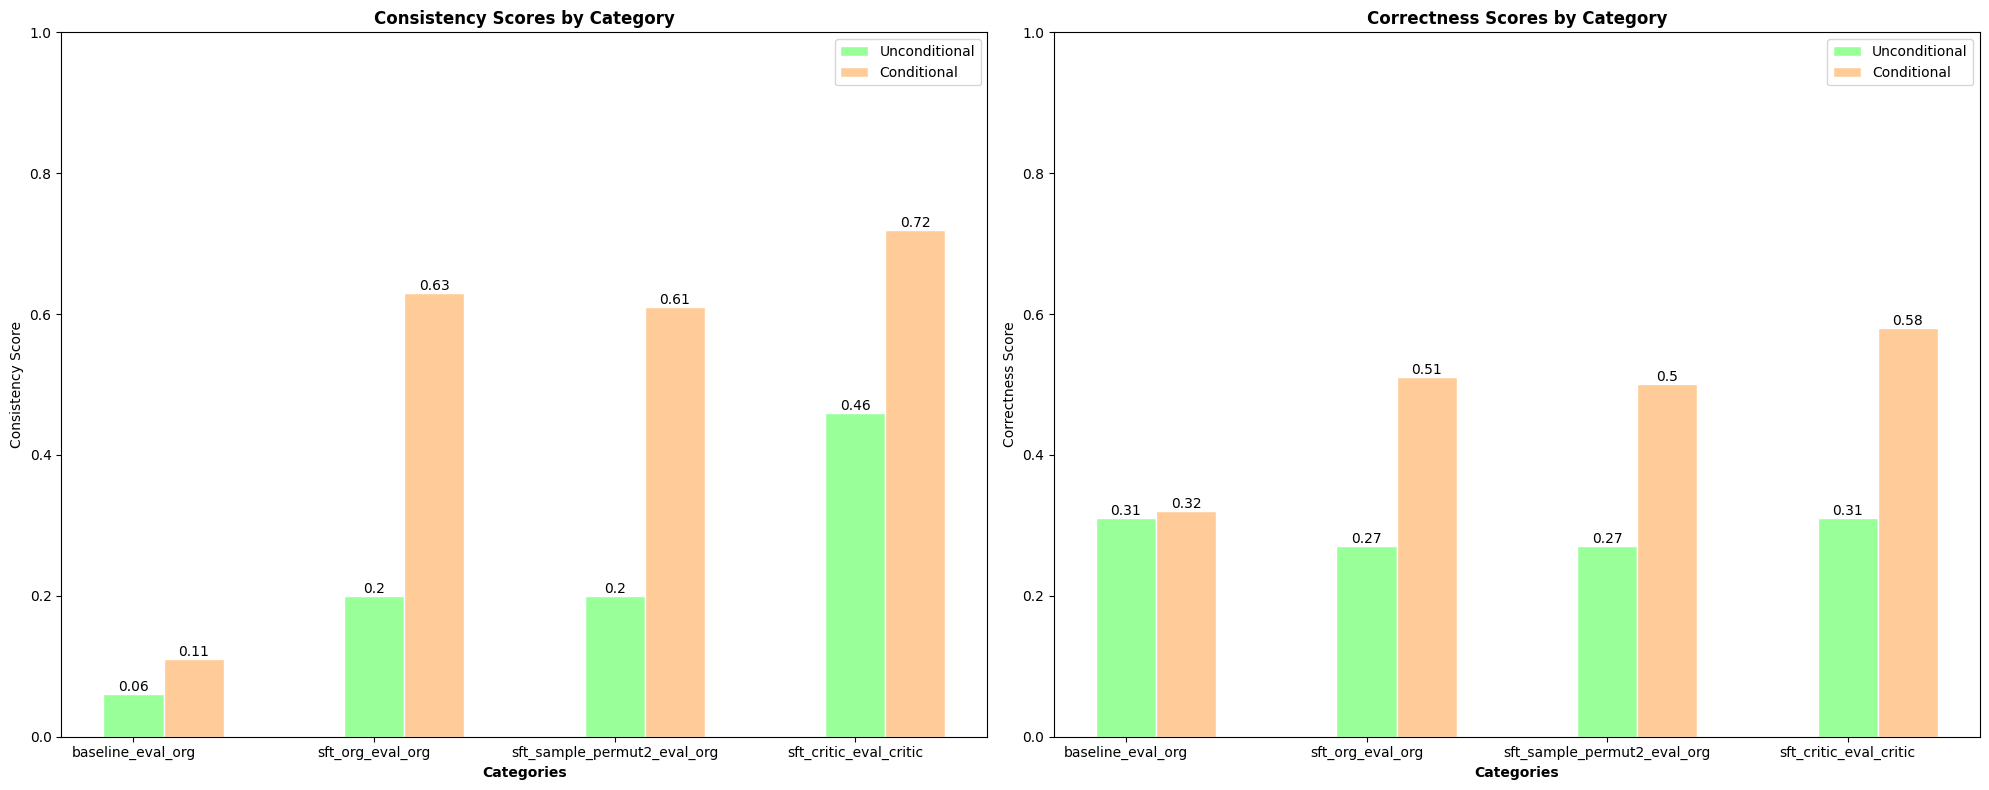

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# Data extraction
categories = ['baseline_eval_org', 'sft_org_eval_org', 'sft_sample_permut2_eval_org',  'sft_critic_eval_critic',  ]
consistency_data = {
    'avg': [round(results[cat]['consistency']['consistency_avg'], 2) for cat in categories],
    'unconditional': [round(results[cat]['consistency']['consistency_unconditional'], 2) for cat in categories],
    'conditional': [round(results[cat]['consistency']['consistency_conditional'], 2) for cat in categories]
}
correctness_data = {
    'avg': [
        round((results[cat]['correctness']['correctness_A_avg'] + results[cat]['correctness']['correctness_B_avg']) / 2, 2)
        for cat in categories
    ],
    'unconditional': [
        round((results[cat]['correctness']['correctness_A_unconditional'] + results[cat]['correctness']['correctness_B_unconditional']) / 2, 2)
        for cat in categories
    ],
    'conditional': [
        round((results[cat]['correctness']['correctness_A_conditional'] + results[cat]['correctness']['correctness_B_conditional']) / 2, 2)
        for cat in categories
    ]
}

# Setting up the figures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Width of a bar
width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(categories))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

# Softer colors for bars
colors = ['#99CCFF', '#99FF99', '#FFCC99']

# Plotting consistency data
# ax1.bar(r1, consistency_data['avg'], color=colors[0], width=width, edgecolor='white', label='Avg')
ax1.bar(r2, consistency_data['unconditional'], color=colors[1], width=width, edgecolor='white', label='Unconditional')
ax1.bar(r3, consistency_data['conditional'], color=colors[2], width=width, edgecolor='white', label='Conditional')

# Adding value labels on top of each bar
# for i, v in enumerate(consistency_data['avg']):
#     ax1.text(r1[i], v, str(v), ha='center', va='bottom')
for i, v in enumerate(consistency_data['unconditional']):
    ax1.text(r2[i], v, str(v), ha='center', va='bottom')
for i, v in enumerate(consistency_data['conditional']):
    ax1.text(r3[i], v, str(v), ha='center', va='bottom')

ax1.set_xlabel('Categories', fontweight='bold')
ax1.set_ylabel('Consistency Score')
ax1.set_title('Consistency Scores by Category', fontweight='bold')
ax1.set_xticks([r + width for r in range(len(categories))])
ax1.set_xticklabels(categories)
ax1.set_ylim(0, 1)  # Setting y-axis limit to [0, 1]
ax1.legend()

# Plotting correctness data
# ax2.bar(r1, correctness_data['avg'], color=colors[0], width=width, edgecolor='white', label='Avg')
ax2.bar(r2, correctness_data['unconditional'], color=colors[1], width=width, edgecolor='white', label='Unconditional')
ax2.bar(r3, correctness_data['conditional'], color=colors[2], width=width, edgecolor='white', label='Conditional')

# Adding value labels on top of each bar
# for i, v in enumerate(correctness_data['avg']):
#     ax2.text(r1[i], v, str(v), ha='center', va='bottom')
for i, v in enumerate(correctness_data['unconditional']):
    ax2.text(r2[i], v, str(v), ha='center', va='bottom')
for i, v in enumerate(correctness_data['conditional']):
    ax2.text(r3[i], v, str(v), ha='center', va='bottom')

ax2.set_xlabel('Categories', fontweight='bold')
ax2.set_ylabel('Correctness Score')
ax2.set_title('Correctness Scores by Category', fontweight='bold')
ax2.set_xticks([r + width for r in range(len(categories))])
ax2.set_xticklabels(categories)
ax2.set_ylim(0, 1)  # Setting y-axis limit to [0, 1]
ax2.legend()

# Adjusting the layout and displaying the plot
plt.tight_layout()
plt.show()

# Inspect GIF eval results

In [28]:
# data_path = "/data/evals/yuchen/gifeval/raw/pmix-sft-27k.yuchen.svc.max.x.ai-k1/2024-11-01-220552/metrics.json" # rfilter 274k
# data_path = "/data/evals/yuchen/gifeval/raw/pmix-org-19k.yuchen.svc.max.x.ai-k1/2024-11-01-220551/metrics.json" # org 192k
data_path = "/data/evals/yuchen/gifeval/raw/pmix-org-16k.yuchen.svc.max.x.ai-k1/2024-11-01-193317/metrics.json" # org 160k
data_path = "/data/evals/yuchen/gifeval/raw/pmix-sft-16k.yuchen.svc.max.x.ai-k1/2024-11-01-193308/metrics.json" # rfilter 160k

data_path = "/data/evals/yuchen/gifeval/raw/npmix-org-288k.yuchen.svc.max.x.ai/2024-11-06-025943/metrics.json" # cleansft org 288k
# data_path = "/data/evals/yuchen/gifeval/raw/npmix-rfilter-192k.yuchen.svc.max.x.ai-k1/2024-11-06-091027/metrics.json" # cleansft rfilter 160k
result = json.load(open(data_path, "r"))
flatten_output = {
    by_k + "_" + win_rate_metric: {
      k + "_" + win_rate_metric : float([vv for vk, vv in v.items() if win_rate_metric in vk][0].split(" (")[0])
      for k, v in result[by_k].items()
    }
    for by_k in result
    for win_rate_metric in ["win_rate_by_label", "win_rate_by_score"]

}
flatten_output
df = pd.DataFrame(flatten_output)
df_flattened = df.stack().reset_index(level=1, drop=True).rename('Value')
df_flattened

Advice_win_rate_by_label            83.56
Brainstorming_win_rate_by_label     63.69
Classification_win_rate_by_label    65.10
Closed QA_win_rate_by_label         59.65
Conversational_win_rate_by_label    51.45
Extraction_win_rate_by_label        59.48
Modification_win_rate_by_label      78.57
Open QA_win_rate_by_label           68.69
Other_win_rate_by_label             61.13
Persona_win_rate_by_label           71.43
Retrieval_win_rate_by_label         90.48
Rewriting_win_rate_by_label         64.39
Summarization_win_rate_by_label     59.98
Writing_win_rate_by_label           65.05
Advice_win_rate_by_score            72.59
Brainstorming_win_rate_by_score     71.85
Classification_win_rate_by_score    63.03
Closed QA_win_rate_by_score         57.04
Conversational_win_rate_by_score    56.67
Extraction_win_rate_by_score        56.36
Modification_win_rate_by_score      76.67
Open QA_win_rate_by_score           67.88
Other_win_rate_by_score             65.93
Persona_win_rate_by_score         

{'Advice': {'accuracy_prompt_level': '40.0 (±3.14)',
  'accuracy_rubric_level': '72.75 (±0.2)',
  'score_prompt_level': '67.73 (±0.35)',
  'score_rubric_level': '66.82 (±0.2)',
  'win_rate_by_label (exclude tie)': '84.35 (±4.72)',
  'wintie_rate_by_label': '91.11 (±3.14)',
  'win_rate_by_score': '69.63 (±2.77)',
  '# of examples': 45.0},
 'Brainstorming': {'accuracy_prompt_level': '25.19 (±4.57)',
  'accuracy_rubric_level': '69.25 (±0.22)',
  'score_prompt_level': '65.73 (±0.73)',
  'score_rubric_level': '66.02 (±0.43)',
  'win_rate_by_label (exclude tie)': '49.85 (±4.72)',
  'wintie_rate_by_label': '71.11 (±1.81)',
  'win_rate_by_score': '51.85 (±1.05)',
  '# of examples': 45.0},
 'Classification': {'accuracy_prompt_level': '16.97 (±0.86)',
  'accuracy_rubric_level': '66.26 (±0.61)',
  'score_prompt_level': '60.83 (±0.46)',
  'score_rubric_level': '63.46 (±0.61)',
  'win_rate_by_label (exclude tie)': '55.25 (±3.01)',
  'wintie_rate_by_label': '68.48 (±3.09)',
  'win_rate_by_score': '5